In [9]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
TARGET_N = 240

def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)

def read_vtk_point_cell_data(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    # 提取按连接顺序排列的坐标
    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])

    # 插值 coords
    resampled_coords = resample_array(coords, TARGET_N)

    # 插值 point data
    point_data = {}
    pd = polydata.GetPointData()
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):  # 只处理与 coords 长度一致的
                resampled = resample_array(data, TARGET_N)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data  # 保留不变

    # 不处理 cell_data，直接保留原始数据
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    return point_data, cell_data, resampled_coords

def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path)
            results[fname] = {
                'point_data': point_data,
                'cell_data': cell_data,
                'coords': coords
            }
    return results

# 用法示例
base_dir = r"D:\!BraVa_src\ica_results\vmtkgeometry_91"
vtk_data_dict = batch_read_vtk_data(base_dir)

all_coords = [vtk_data_dict[name]["coords"] for name in vtk_data_dict]
coords_array = np.stack([vtk_data_dict[name]["coords"] for name in vtk_data_dict], axis=0)
# 所有曲线平移，使起点对齐到 [0, 0, 0]
coords_array = coords_array - coords_array[:, 0:1, :]
# 广播减法，coords_array[:, 0:1, :] shape 为 [N_samples, 1, 3]

In [55]:
# for fname, content in vtk_data_dict.items():
#     point_attrs = content['point_data']
#     cell_attrs = content['cell_data']
#     coords = content['coords']

#     print(f"{fname}:")
#     print(f"  Point attributes ({len(point_attrs)}): {list(point_attrs.keys())}")
#     print(f"  Cell attributes ({len(cell_attrs)}): {list(cell_attrs.keys())}")
#     print(f"  Points (coords): {coords.shape[0]}")
#     print("-" * 60)

# print(list(vtk_data_dict.keys()))
# 收集所有 length 数值
all_lengths = []
for fname, content in vtk_data_dict.items():
    length = content['cell_data']['Length']  # 通常是一个数值或一维数组
    # 如果是 array 取第一个元素
    if isinstance(length, (list, np.ndarray)):
        length = float(np.ravel(length)[0])
    all_lengths.append(length)

# 计算均值和方差
mean_length = np.mean(all_lengths)
var_length = np.var(all_lengths, ddof=1)  # ddof=1 得到样本方差

print("Mean Length:", mean_length)
print("Variance of Length:", var_length)

Mean Length: 74.89519148981852
Variance of Length: 65.29577429390878


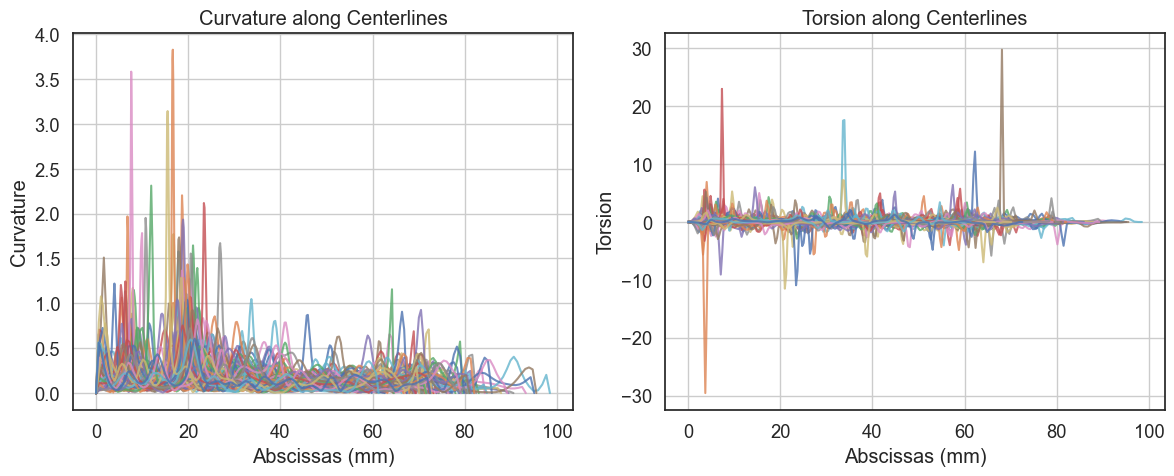

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# curvature subplot
plt.subplot(1, 2, 1)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Curvature' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Curvature'], label=fname, alpha=0.8)
plt.title("Curvature along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Curvature")
plt.grid(True)

# torsion subplot
plt.subplot(1, 2, 2)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Torsion' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Torsion'], label=fname, alpha=0.8)
plt.title("Torsion along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Torsion")
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
from io import StringIO
import sys
import re
import csv

class OutputCatcher:
    def __init__(self):
        self._stdout = sys.stdout
        self.buffer = StringIO()

    def __enter__(self):
        sys.stdout = self.buffer
        return self

    def __exit__(self, *args):
        sys.stdout = self._stdout

    def get(self):
        return self.buffer.getvalue()

def parse_alignment_log(log_text):
    pattern_iter = re.compile(r"(updating step: r=|Iteration )(\d+)")
    pattern_residual = re.compile(r"Residual(?: Change)?: ([\d\.]+)")
    pattern_energy = re.compile(r"Residual Energy: ([\d\.]+)")

    results = {}
    current_iter = None

    for line in log_text.splitlines():
        iter_match = pattern_iter.search(line)
        if iter_match:
            current_iter = int(iter_match.group(2))
            if current_iter not in results:
                results[current_iter] = {'iter': current_iter}

        res_match = pattern_residual.search(line)
        if res_match and current_iter is not None:
            results[current_iter]['residual'] = float(res_match.group(1))

        ene_match = pattern_energy.search(line)
        if ene_match and current_iter is not None:
            results[current_iter]['energy'] = float(ene_match.group(1))

    # 转成列表并排序
    return [results[k] for k in sorted(results)]


def write_log_to_csv(results, filename):
    with open(filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["iter", "residual", "energy"])
        writer.writeheader()
        writer.writerows(results)
    print(f"[log] Wrote {len(results)} rows to {filename}")


[log] Wrote 20 rows to ./alignment_plain.csv
[log] Wrote 20 rows to ./alignment_weighted.csv


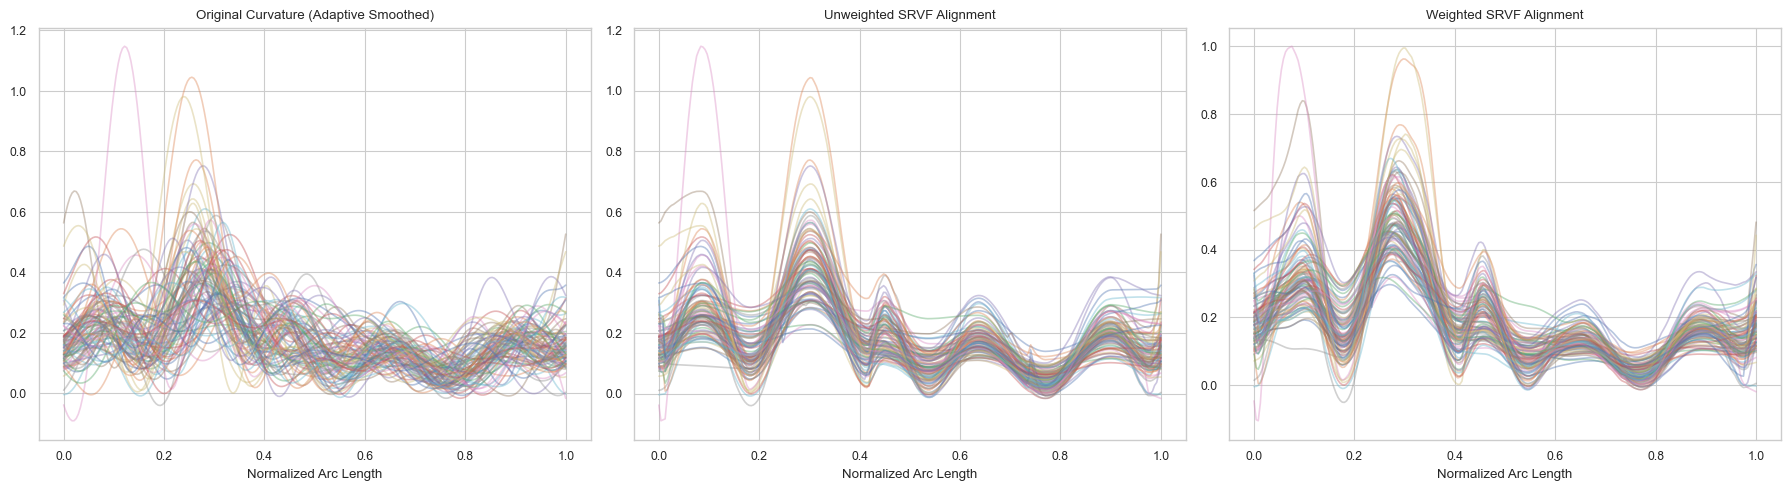

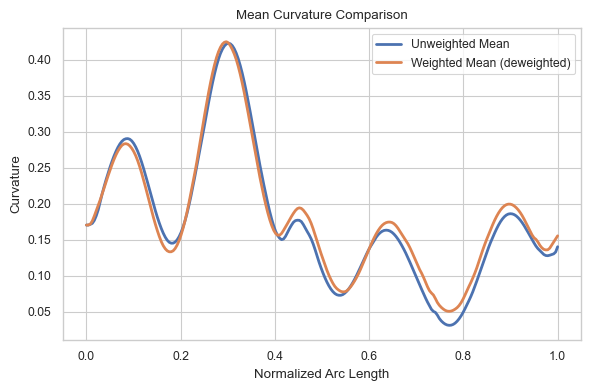

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from fdasrsf.utility_functions import resamplefunction
from fdasrsf.time_warping import fdawarp
import seaborn as sns

sns.set(style="whitegrid", context="paper", font_scale=1)
# 参数
# # target_len = 200
# target_len = 500  # 目标长度
t_resample = np.linspace(0, 1, TARGET_N )
alpha_s = 0.75

# Fourier 平滑函数
def fourier_lowpass(signal, keep_ratio):
    N = len(signal)
    fhat = fft(signal)
    keep = int(N * keep_ratio)
    fhat[keep:-keep] = 0
    return np.real(ifft(fhat))

# 自适应平滑函数：使平滑后曲线具有约 5 个峰
def adaptive_fourier_smoothing(signal, peak_target=5, tol=1, max_iter=50):
    ratios = np.linspace(0.01, 0.2, 100)
    for r in ratios:
        smoothed = fourier_lowpass(signal, keep_ratio=r)
        peaks, _ = find_peaks(smoothed,
                                prominence=(np.max(smoothed) - np.min(smoothed)) * 0.08,
                                distance=TARGET_N  // 10  # 避免过密峰值
                            )
        if abs(len(peaks) - peak_target) <= tol:
            return smoothed
    return fourier_lowpass(signal, keep_ratio=0.03)

# 结构权重函数（使用自适应傅立叶平滑）
def composite_weight(curves, alpha_s=0.75):
    """
    使用 adaptive Fourier smoothing 后的结构强度生成逐点加权权重。
    - curves: ndarray of shape [T, N]
    - alpha_s: 放大系数（越大越强调曲率突变区域）
    
    返回:
        weights: ndarray of shape [T, N]
    """
    T, N = curves.shape

    # Step 1: 对每条曲线使用 adaptive smoothing
    smoothed_curves = np.stack([
        adaptive_fourier_smoothing(curves[:, i], peak_target=5, tol=1)
        for i in range(N)
    ], axis=1)

    # Step 2: 局部结构强度（曲率绝对值）
    mag = np.abs(smoothed_curves)

    # Step 3: 一致性系数（强调 across-curves 一致的区域）
    consistency = 1.0 / (np.std(smoothed_curves, axis=1) + 1e-5)
    consistency = (consistency - consistency.min()) / (consistency.max() - consistency.min() + 1e-8)
    consistency = consistency[:, None]  # shape [T, 1]

    # Step 4: 综合权重计算
    weights = (1 + alpha_s * mag) * (0.5 + 0.5 * consistency)

    # Step 5: 全局归一化
    weights /= (weights.mean() + 1e-8)

    return weights  # shape [T, N]


# 主流程
names = list(vtk_data_dict.keys())
resampled_curves = []

for name in names:
    curvature = vtk_data_dict[name]["point_data"]["Curvature"]
    coords = vtk_data_dict[name]["coords"]

    # 不再重新插值，只保留 smoothing（输入已经是500点）
    curvature = adaptive_fourier_smoothing(curvature, peak_target=5, tol=1)
    resampled_curves.append(curvature)


f = np.stack(resampled_curves).T
time = t_resample
MaxItr = 20
# # 不加权对齐
with OutputCatcher() as capture_plain:
    obj_plain = fdawarp(f.copy(), time)
    obj_plain.srsf_align(parallel=True, MaxItr=MaxItr, verbose=True)

plain_log = capture_plain.get()
plain_results = parse_alignment_log(plain_log)
write_log_to_csv(plain_results, "./alignment_plain.csv")

# 加权对齐
W = composite_weight(f, alpha_s=alpha_s)
obj_weighted = fdawarp(f.copy(), time)
obj_weighted.custom_weights = W.mean(axis=0)  # 向自定义方法传权重
alpha_init = 0.05
# momentum_beta = 0.9
momentum_beta1= 0.9
momentum_beta2 = 0.999

with OutputCatcher() as capture_weighted:
    obj_weighted.srsf_align_weighted(
        pointwise_weights=W,
        MaxItr=MaxItr,
        parallel=True,
        alpha=alpha_init,
        use_momentum=True,
        beta1=momentum_beta1,
        beta2=momentum_beta2
    )

weighted_log = capture_weighted.get()
weighted_results = parse_alignment_log(weighted_log)
write_log_to_csv(weighted_results, "./alignment_weighted.csv")


# 恢复加权后数据
f_weighted_unwrapped = obj_weighted.fn / W
# f_weighted_unwrapped = obj_weighted.fn

# 可视化
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for i in range(f.shape[1]):
    plt.plot(time, f[:, i], alpha=0.4)
plt.title("Original Curvature (Adaptive Smoothed)")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 2)
for i in range(f.shape[1]):
    plt.plot(time, obj_plain.fn[:, i], alpha=0.4)
plt.title("Unweighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(f.shape[1]):
    plt.plot(time, f_weighted_unwrapped[:, i], alpha=0.4)
plt.title("Weighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# 平均曲率比较
plt.figure(figsize=(6, 4))
plt.plot(time, obj_plain.fmean, label='Unweighted Mean', lw=2)
plt.plot(time, obj_weighted.fmean, label='Weighted Mean (deweighted)', lw=2)
plt.xlabel("Normalized Arc Length")
plt.ylabel("Curvature")
plt.title("Mean Curvature Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

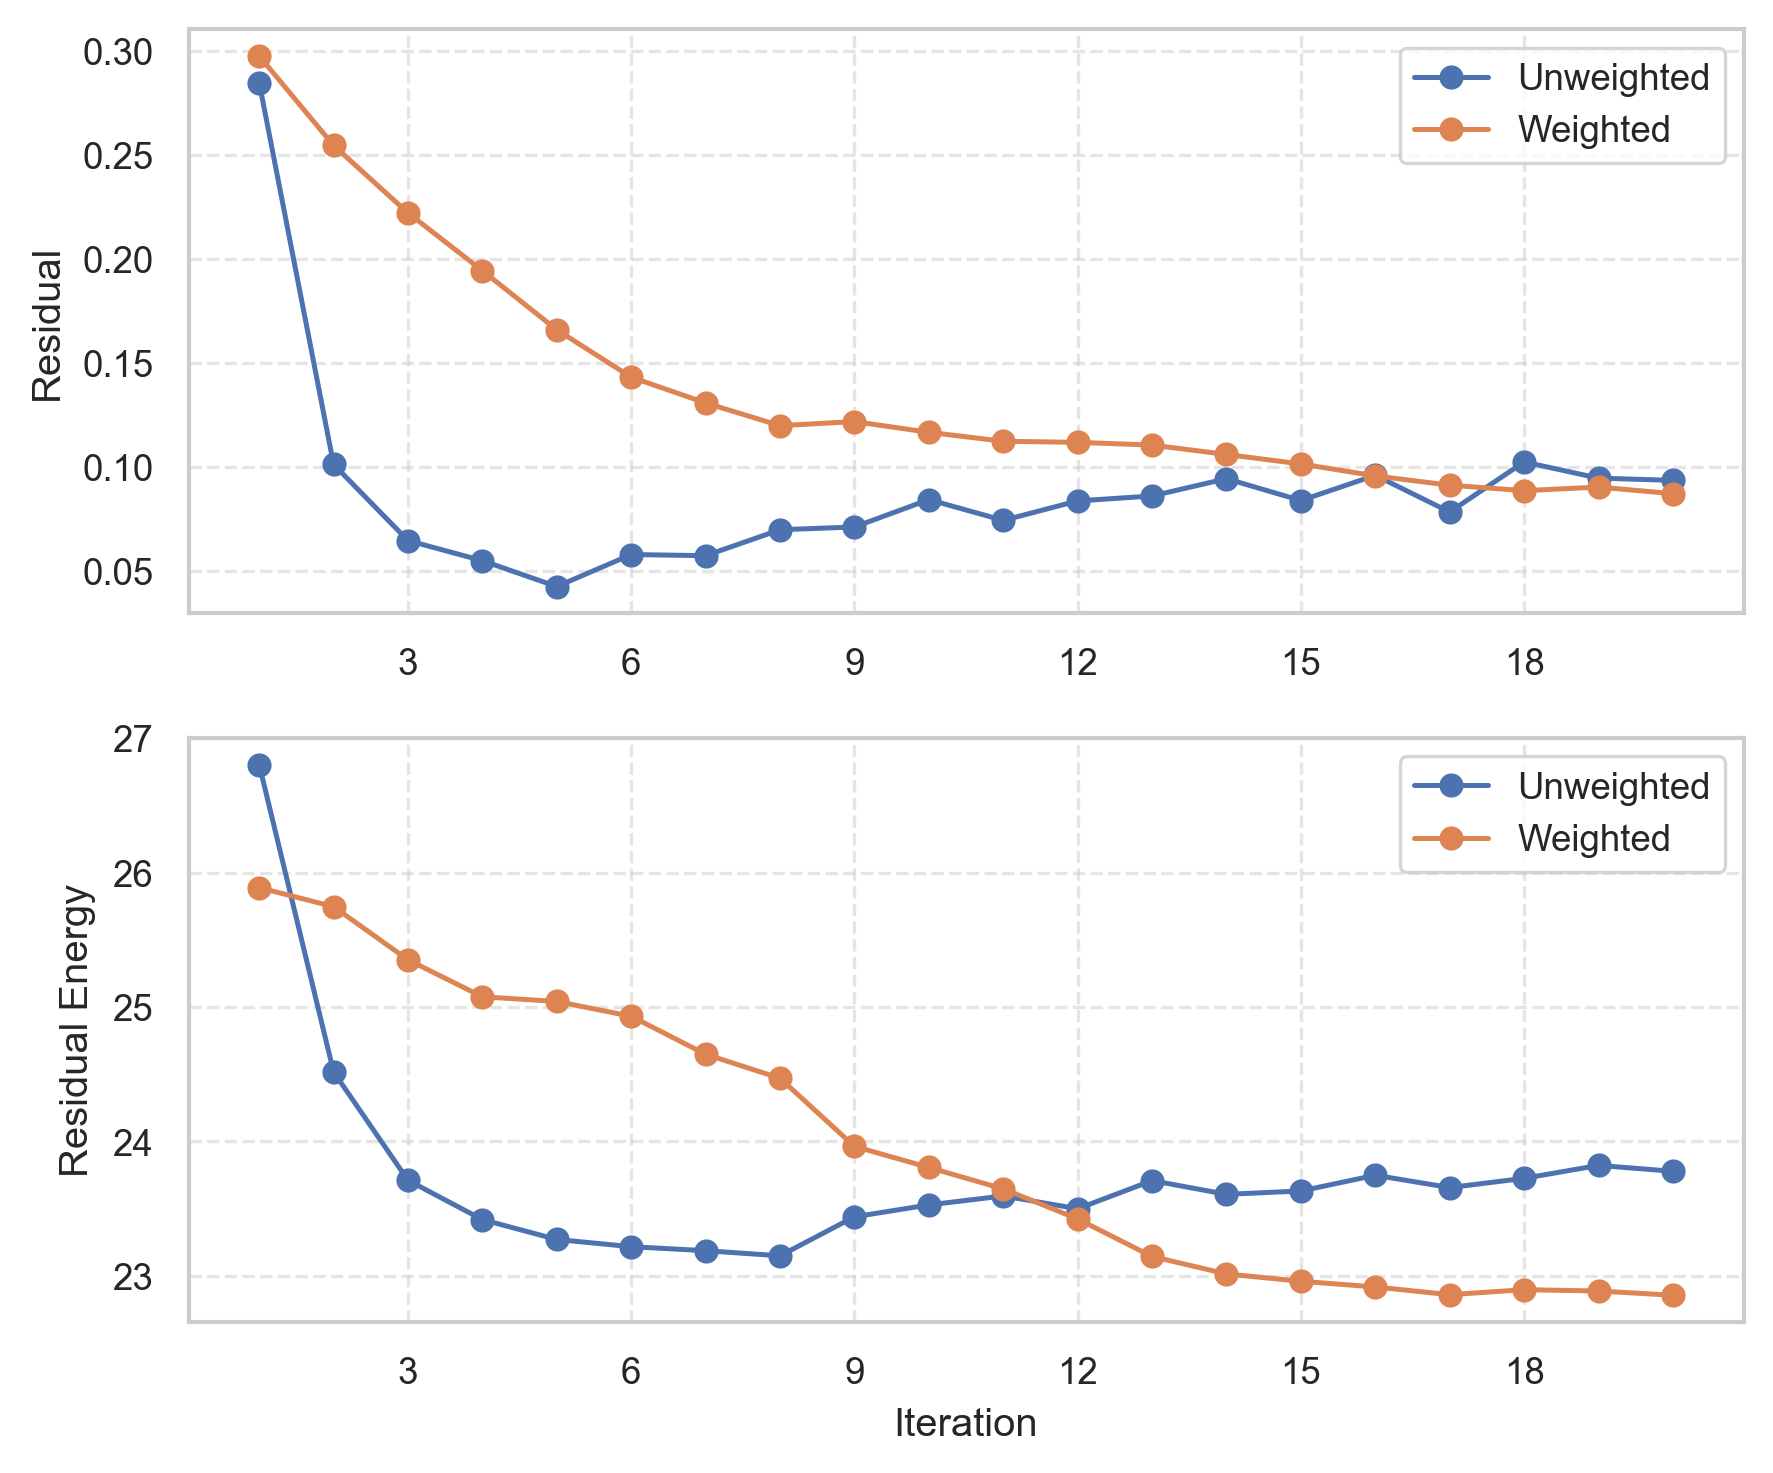

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1. 读取两个CSV文件
df_plain = pd.read_csv("./alignment_plain.csv")
df_weighted = pd.read_csv("./alignment_weighted.csv")

# 保证 iter 列是整数
df_plain["iter"] = df_plain["iter"].astype(int)
df_weighted["iter"] = df_weighted["iter"].astype(int)

plt.figure(figsize=(6,5), dpi=300)

# --- Residual ---
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df_plain["iter"], df_plain["residual"], label="Unweighted", marker='o')
ax1.plot(df_weighted["iter"], df_weighted["residual"], label="Weighted", marker='o')
ax1.set_ylabel("Residual")
ax1.legend()
ax1.grid(linestyle='--', alpha=0.5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Energy ---
ax2 = plt.subplot(2, 1, 2)
ax2.plot(df_plain["iter"], df_plain["energy"], label="Unweighted", marker='o')
ax2.plot(df_weighted["iter"], df_weighted["energy"], label="Weighted", marker='o')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Residual Energy")
ax2.legend()
ax2.grid(linestyle='--', alpha=0.5)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


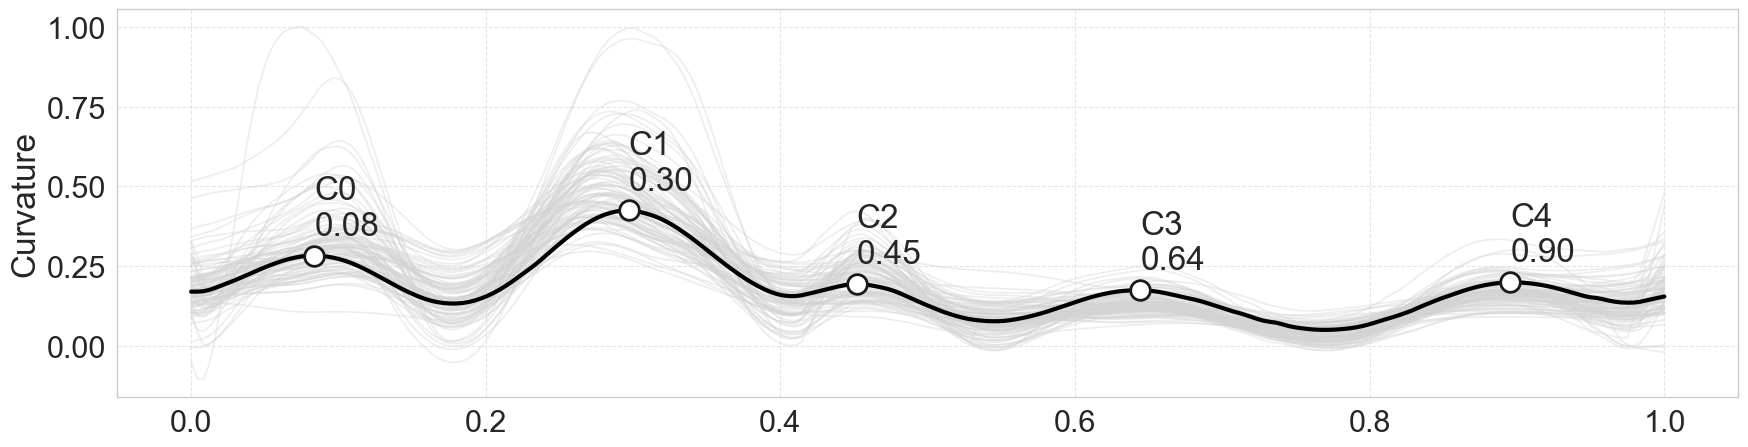

In [15]:
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="whitegrid", context="paper", font_scale=2.5)

# 计算去权重后的平均曲线
# mean_curve = obj_weighted.fmean / W.mean(axis=1)
mean_curve = obj_weighted.fmean

# 寻找峰值点
peaks, _ = find_peaks(
    mean_curve,
    prominence=(np.max(mean_curve) - np.min(mean_curve)) * 0.08,  # 自适应prominence
    distance=TARGET_N // 10                                     # 控制峰值间距（25点）
)

# 将峰值按 x 坐标排序（从左到右）
sorted_peaks = peaks[np.argsort(time[peaks])]

# 可视化
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(111)

# 所有对齐曲线
for i in range(f.shape[1]):
    ax.plot(time, f_weighted_unwrapped[:, i], alpha=0.4, color='lightgray')

# 平均曲线
ax.plot(time, mean_curve, label='Weighted Mean (deweighted)', lw=3, color='black')

# 标注峰值
ax.scatter(time[sorted_peaks], mean_curve[sorted_peaks],
           color='white', edgecolors='k', linewidths=2,
           s=200, zorder=10, label='Peaks')

# 添加标注文字 C0 ~ Cn 和对应高度
for i, idx in enumerate(sorted_peaks):
    peak_x = time[idx]
    peak_y = mean_curve[idx]
    ax.annotate(f"C{i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                xytext=(0, 10), textcoords='offset points',
                ha='left', va='bottom', fontsize=24,
                arrowprops=dict(arrowstyle='-', lw=1))

# 标签和网格
ax.set_ylabel("Curvature")
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.legend()
plt.show()


In [16]:


sns.set(style="white", context="notebook", font_scale=1.2)

# # ------------------------------------------------------------
# # === Part 1: Time Shifts at Peaks (Blue Theme) ===
# # ------------------------------------------------------------

# # 1️⃣ 计算所有样本在mean曲线的C0~Cn处的时间shift
# gammas = obj_weighted.gam.T   # shape (n_samples, len(time))
# peak_times = time[sorted_peaks]   # mean曲线的峰值位置

# n_samples = gammas.shape[0]
# n_peaks = len(peak_times)
# shifts = np.zeros((n_samples, n_peaks))

# # # ✅ 关键改动：C1位置
# # c1_time = peak_times[1]

# # for i in range(n_samples):
# #     f_gamma = interp1d(time, gammas[i, :], kind='linear', bounds_error=False, fill_value="extrapolate")
    
# #     # γ_i 在所有 peaks 上的值
# #     gamma_peaks = f_gamma(peak_times)
    
# #     # γ_i 在C1处的值
# #     gamma_c1 = f_gamma(c1_time)
    
# #     # 对齐：C1处位移为0
# #     shifts[i, :] = (gamma_peaks - gamma_c1) - (peak_times - c1_time)

# # ✅ 新基准：所有峰的平均位置（中点）
# mid_time = np.mean(peak_times)

# for i in range(n_samples):
#     f_gamma = interp1d(time, gammas[i, :], kind='linear', bounds_error=False, fill_value="extrapolate")

#     gamma_peaks = f_gamma(peak_times)     # 每个样本在每个峰的 gamma 值
#     gamma_mid = f_gamma(mid_time)         # 在中点处的 gamma 值

#     # 每个样本的相对偏移量（相对于 mid_time）
#     # shifts[i, :] = (gamma_peaks - gamma_mid) - (peak_times - mid_time)
#     shifts[i, :] = gamma_peaks - peak_times

# # ------------------------------------------------------------
# # 2️⃣ 整理为 DataFrame
# shift_df = pd.DataFrame(shifts, columns=[f'C{i}' for i in range(n_peaks)])
# # shift_df = shift_df.drop(columns=[f'C1'])
# # ------------------------------------------------------------
# # 3️⃣ 统一颜色和绘图函数
# blue_color = 'lightskyblue'

# def diag_hist_blue(x, **kwargs):
#     ax = plt.gca()
#     sns.histplot(x, bins=20, color=blue_color, edgecolor='black', ax=ax)

# def offdiag_scatter_with_r_blue(x, y, **kwargs):
#     ax = plt.gca()
#     ax.scatter(x, y, alpha=0.4, color=blue_color, edgecolor='k')
#     r = np.corrcoef(x, y)[0, 1]
#     ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
#                 ha='left', va='center', fontsize=12, fontweight='bold', color='black')

# # ------------------------------------------------------------
# # 4️⃣ 画 PairGrid
# g = sns.PairGrid(shift_df, corner=False)
# g.map_diag(diag_hist_blue)
# g.map_offdiag(offdiag_scatter_with_r_blue)

# # plt.suptitle('Pairwise Relationships of Time Shifts at Peaks (C1-Aligned)', y=1.02)
# plt.show()

# # ------------------------------------------------------------
# # === Part 2: Curvature Values at Peaks (Red Theme) ===
# # ------------------------------------------------------------

# print(f"f_weighted_unwrapped shape: {f_weighted_unwrapped.shape}")
# print(f"Number of samples: {f_weighted_unwrapped.shape[1]}")
# print(f"Number of peaks: {len(peak_times)}")

# from scipy.interpolate import interp1d
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="white", context="notebook", font_scale=1.2)

# # === 输入变量假定已有 ===
# # time: 1D numpy array
# # peak_times: 1D array of selected peak locations on mean curve
# # f_weighted_unwrapped: shape (len(time), n_samples)
# # mean_curve: shape (len(time),), already defined

# # 1️⃣ 计算每个样本在 peak_times 上的曲率值，并归一化为相对于 mean_curve 的比值
# n_peaks = len(peak_times)
# n_samples = f_weighted_unwrapped.shape[1]
# values_at_peaks = np.zeros((n_samples, n_peaks))

# # 插值 mean 曲线，在 peak_times 上的基准值
# f_mean_interp = interp1d(time, mean_curve, kind='linear', bounds_error=False, fill_value="extrapolate")
# mean_values_at_peaks = f_mean_interp(peak_times)

# # 防止除以 0（数值稳定性）
# epsilon = 1e-8
# mean_values_at_peaks = mean_values_at_peaks + epsilon

# # 每个样本在这些点的曲率 / mean 曲线对应位置的曲率
# for i in range(n_samples):
#     f_interp = interp1d(time, f_weighted_unwrapped[:, i], kind='linear', bounds_error=False, fill_value="extrapolate")
#     values_at_peaks[i, :] = f_interp(peak_times)

# value_ratios = values_at_peaks / mean_values_at_peaks

# value_df = pd.DataFrame(value_ratios, columns=[f'C{i}' for i in range(n_peaks)])
# print("\nRatio to mean_curve at peaks:")
# print(value_df.head())

# # 2️⃣ 绘图颜色和函数
# red_color = 'lightcoral'

# def diag_hist_red(x, **kwargs):
#     ax = plt.gca()
#     sns.histplot(x, bins=20, color=red_color, edgecolor='black', ax=ax)

# def offdiag_scatter_with_r_red(x, y, **kwargs):
#     ax = plt.gca()
#     ax.scatter(x, y, alpha=0.4, color=red_color, edgecolor='k')
#     r = np.corrcoef(x, y)[0, 1]
#     ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
#                 ha='left', va='center', fontsize=12, fontweight='bold', color='black')

# # 3️⃣ PairGrid 绘图
# g = sns.PairGrid(value_df, corner=False)
# g.map_diag(diag_hist_red)
# g.map_offdiag(offdiag_scatter_with_r_red)

# # plt.suptitle('Pairwise Relationships of Curvature Ratio at Peaks (Red Theme)', y=1.02)
# plt.show()


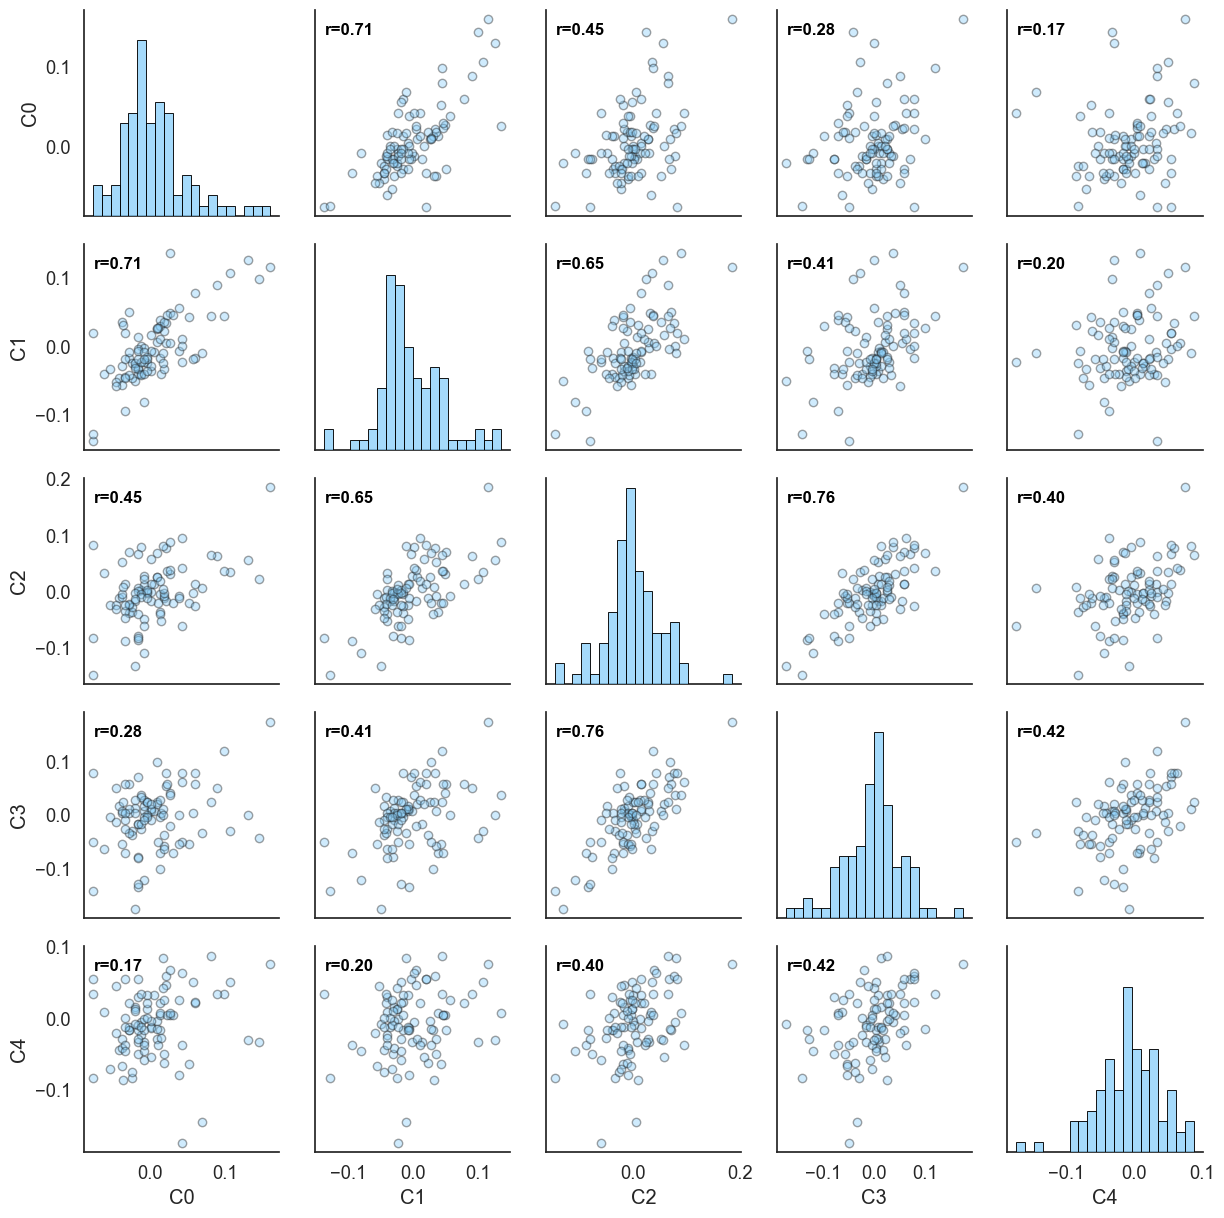

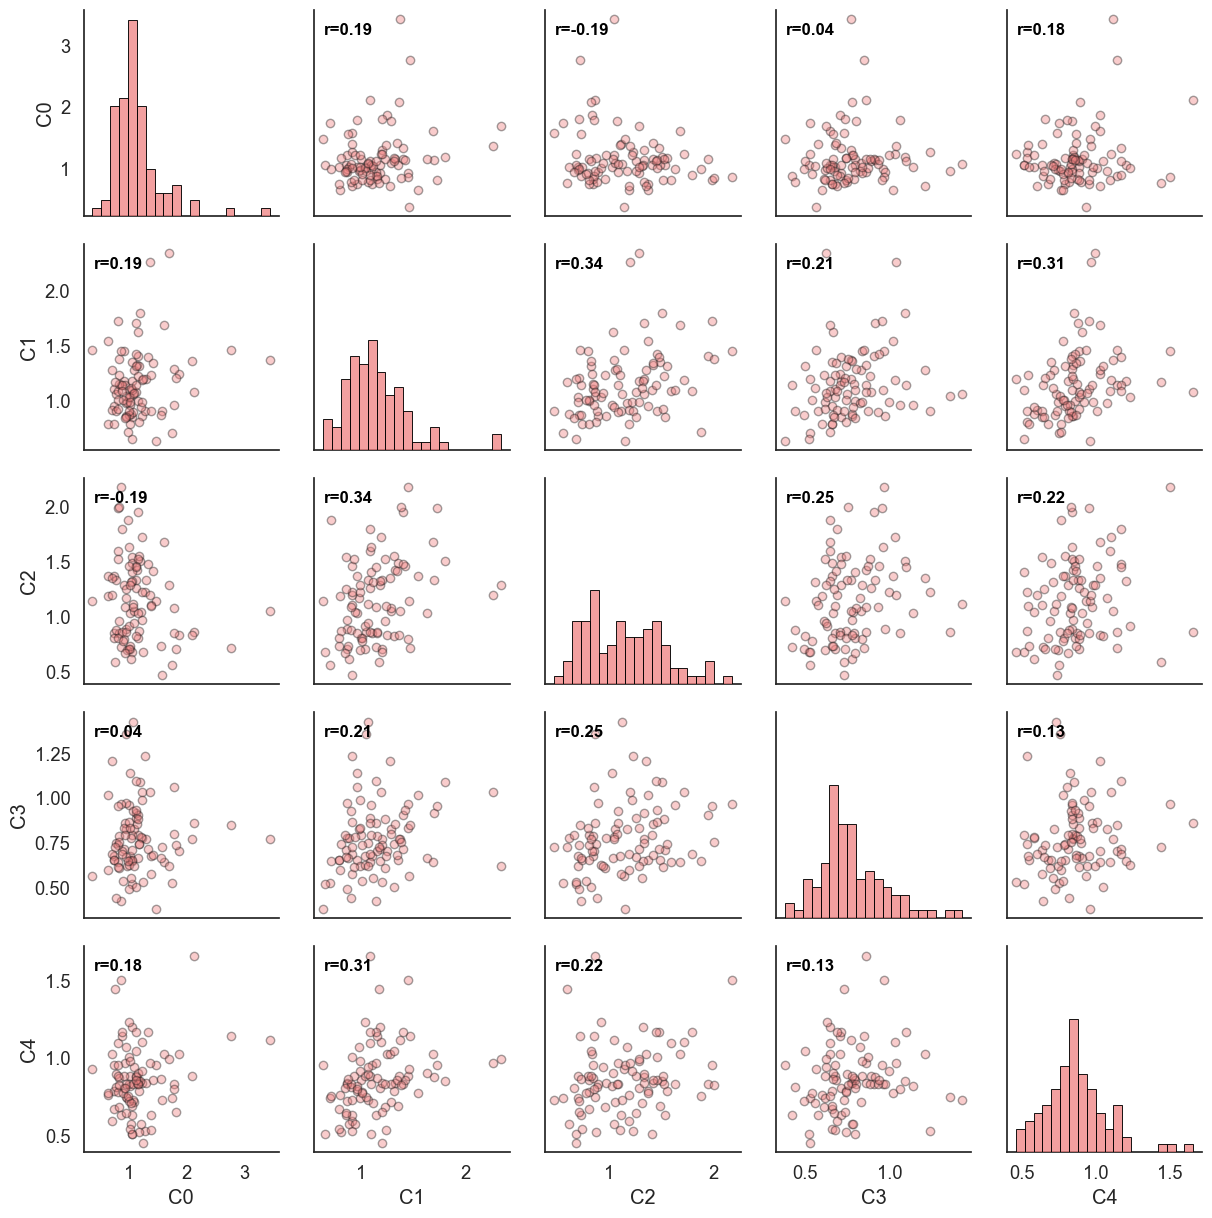

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

sns.set(style="white", context="notebook", font_scale=1.2)


def compute_and_plot_pairwise_matrix(
    data_matrix,         # shape: (len(time), n_samples)
    reference_curve,     # shape: (len(time),)
    time,                # time axis
    peak_times,          # peak locations on the mean curve
    method="difference", # "difference" or "ratio"
    color="skyblue",     # color theme
    title=None
):
    """
    对每个样本在 peak_times 上插值并与参考曲线对比，绘制 pairwise 关系图。

    Parameters:
        data_matrix: shape (len(time), n_samples)
        reference_curve: 1D array of same length as time
        time: 1D array
        peak_times: 1D array
        method: "difference" or "ratio"
        color: matplotlib color string
        title: optional plot title
    """
    n_samples = data_matrix.shape[1]
    n_peaks = len(peak_times)
    values_at_peaks = np.zeros((n_samples, n_peaks))

    # 插值 reference 曲线
    ref_interp = interp1d(time, reference_curve, kind='linear', bounds_error=False, fill_value="extrapolate")
    ref_values_at_peaks = ref_interp(peak_times)

    if method == "ratio":
        epsilon = 1e-8
        ref_values_at_peaks = ref_values_at_peaks + epsilon

    # 插值每个样本
    for i in range(n_samples):
        f_interp = interp1d(time, data_matrix[:, i], kind='linear', bounds_error=False, fill_value="extrapolate")
        values_at_peaks[i, :] = f_interp(peak_times)

    # 差值或比值
    if method == "difference":
        comparison_matrix = values_at_peaks - ref_values_at_peaks
    elif method == "ratio":
        comparison_matrix = values_at_peaks / ref_values_at_peaks
    else:
        raise ValueError("Invalid method. Use 'difference' or 'ratio'.")

    # 构建 DataFrame
    df = pd.DataFrame(comparison_matrix, columns=[f'C{i}' for i in range(n_peaks)])

    # 绘图函数定义
    def diag_hist(x, **kwargs):
        ax = plt.gca()
        sns.histplot(x, bins=20, color=color, edgecolor='black', ax=ax)

    def offdiag_scatter_with_r(x, y, **kwargs):
        ax = plt.gca()
        ax.scatter(x, y, alpha=0.4, color=color, edgecolor='k')
        r = np.corrcoef(x, y)[0, 1]
        ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
                    ha='left', va='center', fontsize=12, fontweight='bold', color='black')

    # PairGrid
    g = sns.PairGrid(df, corner=False)
    g.map_diag(diag_hist)
    g.map_offdiag(offdiag_scatter_with_r)

    if title:
        plt.suptitle(title, y=1.02)
    plt.show()



peak_times = time[sorted_peaks]   # mean曲线的峰值位置


gammas = obj_weighted.gam.T  # shape: (n_samples, len(time))
gammas = gammas.T            # transpose to (len(time), n_samples)
reference_gamma = time       # gamma 应该与 time 对比

compute_and_plot_pairwise_matrix(
    data_matrix=gammas,
    reference_curve=reference_gamma,
    time=time,
    peak_times=peak_times,
    method="difference",     # 计算时间偏移量
    color="lightskyblue",
    # title="Pairwise Time Shifts at Peaks"
)


compute_and_plot_pairwise_matrix(
    data_matrix=f_weighted_unwrapped,
    reference_curve=mean_curve,
    time=time,
    peak_times=peak_times,
    method="ratio",          # 计算值相对 mean 的比值
    color="lightcoral",
    # title="Pairwise Curvature Ratios at Peaks"
)


In [38]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from matplotlib.ticker import MaxNLocator

# === IEEE-friendly 全局参数 ===
IEEE_SINGLE_COL_W_IN = 3.45  # 单栏宽度
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "STIX"],
    "mathtext.fontset": "stix",
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})
sns.set(style="white", context="paper", font_scale=1.0)


def compute_and_plot_pairwise_matrix(
    data_matrix,         # shape: (len(time), n_samples)
    reference_curve,     # shape: (len(time),)
    time,                # 1D
    peak_times,          # 1D
    method="difference", # "difference" or "ratio"
    color="skyblue",
    title=None,
    outfile=None,        # 推荐传 .pdf 路径
    width_in=IEEE_SINGLE_COL_W_IN,
    height_in=None,
):
    n_samples = data_matrix.shape[1]
    n_peaks = len(peak_times)

    values_at_peaks = np.zeros((n_samples, n_peaks))
    ref_interp = interp1d(time, reference_curve, kind='linear',
                          bounds_error=False, fill_value="extrapolate")
    ref_values_at_peaks = ref_interp(peak_times)

    if method == "ratio":
        epsilon = 1e-8
        ref_values_at_peaks = ref_values_at_peaks + epsilon

    for i in range(n_samples):
        f_interp = interp1d(time, data_matrix[:, i], kind='linear',
                            bounds_error=False, fill_value="extrapolate")
        values_at_peaks[i, :] = f_interp(peak_times)

    if method == "difference":
        comparison_matrix = values_at_peaks - ref_values_at_peaks
    elif method == "ratio":
        comparison_matrix = values_at_peaks / ref_values_at_peaks
    else:
        raise ValueError("Invalid method. Use 'difference' or 'ratio'.")

    df = pd.DataFrame(comparison_matrix,
                      columns=[f'C{i}' for i in range(n_peaks)])

    # === 绘图 ===
    def diag_hist(x, **kwargs):
        ax = plt.gca()
        sns.histplot(x, bins=20, color=color,
                     edgecolor='black', ax=ax, linewidth=0.5)

    def offdiag_scatter_with_r(x, y, **kwargs):
        ax = plt.gca()
        ax.scatter(x, y, alpha=0.5, s=10, color=color,
                   edgecolors='k', linewidths=0.3)
        r = np.corrcoef(x, y)[0, 1]
        ax.annotate(f"r={r:.2f}", xy=(0.04, 0.92),
                    xycoords='axes fraction', ha='left',
                    va='center', fontsize=8,
                    fontweight='bold', color='black')

    g = sns.PairGrid(df, corner=False)
    g.map_diag(diag_hist)
    g.map_offdiag(offdiag_scatter_with_r)

    # === 整理刻度与标签 ===
    for i, ax_row in enumerate(g.axes):
        for j, ax in enumerate(ax_row):
            if ax is not None:
                ax.grid(True, linewidth=0.3, alpha=0.3)
                ax.tick_params(length=3, width=0.6)
                ax.xaxis.set_major_locator(
                    MaxNLocator(nbins=4, prune="both"))
                ax.yaxis.set_major_locator(
                    MaxNLocator(nbins=4, prune="both"))
                # 去掉内部子图的标签
                if i < n_peaks - 1:  # 非底行
                    ax.set_xlabel("")
                    ax.set_xticklabels([])
                if j > 0:  # 非第一列
                    ax.set_ylabel("")
                    ax.set_yticklabels([])

    # 尺寸
    if height_in is None:
        per_cell = 0.9
        height_in = max(2.6, min(10.0, per_cell * n_peaks))
    g.fig.set_size_inches(width_in, height_in)

    if title:
        g.fig.suptitle(title, y=0.995, fontsize=9)

    g.fig.tight_layout(pad=0.6)
    if outfile:
        g.fig.savefig(outfile, bbox_inches="tight")
        plt.close(g.fig)
    else:
        plt.show()


# === 调用示例 ===

# 时间偏移
compute_and_plot_pairwise_matrix(
    data_matrix=gammas,
    reference_curve=reference_gamma,
    time=time,
    peak_times=peak_times,
    method="difference",
    color="lightskyblue",
    outfile="img/shift_pairwise.pdf",
)

# 曲率比值
compute_and_plot_pairwise_matrix(
    data_matrix=f_weighted_unwrapped,
    reference_curve=mean_curve,
    time=time,
    peak_times=peak_times,
    method="ratio",
    color="lightcoral",
    outfile="img/intensity_pairwise.pdf",
)


INFO: maxp pruned
INFO: LTSH dropped
INFO: cmap pruned
INFO: kern dropped
INFO: post pruned
INFO: PCLT dropped
INFO: GPOS pruned
INFO: GSUB pruned
INFO: JSTF dropped
INFO: meta dropped
INFO: DSIG dropped
INFO: name pruned
INFO: glyf pruned
INFO: Added gid0 to subset
INFO: Added first four glyphs to subset
INFO: Closing glyph list over 'GSUB': 10 glyphs before
INFO: Glyph names: ['.notdef', 'C', 'four', 'glyph00001', 'glyph00002', 'one', 'space', 'three', 'two', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 38]
INFO: Closed glyph list over 'GSUB': 20 glyphs after
INFO: Glyph names: ['.notdef', 'C', 'four', 'glyph00001', 'glyph00002', 'glyph03674', 'glyph03675', 'glyph03676', 'glyph03677', 'glyph03678', 'one', 'space', 'three', 'two', 'uni00B2', 'uni00B3', 'uni00B9', 'uni2070', 'uni2074', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 38, 239, 240, 241, 3674, 3675, 3676, 3677, 3678, 3686, 3774]
INFO: Closing glyph list over 'glyf': 20 glyphs before
INFO: Glyph 

In [ ]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.signal import find_peaks
from matplotlib import cm
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from AngioMorphPCA.make_figures import set_x_ticks_normalized
import fdasrsf as fs
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage import measure
import vtk
import pandas as pd

from scipy.ndimage import gaussian_filter
sns.set_context('notebook', font_scale=1.2)
from scipy.integrate import simps


def preprocess_open_curve(curve, target_k=100):
    """
    对3D开曲线进行标准化处理：
    - 起点对齐
    - 重采样为 target_k+1 个点（以便后续删去起点）
    - 缩放为单位弧长
    - 去除首点（避免 SRVMetric 奇异）

    返回：
    - processed_curve: 长度为1的统一曲线 (target_k, 3)，不含首点
    - original_length: 原始长度（用于逆缩放）
    """
    # 起点平移
    curve = curve - curve[0]

    # 原始参数化（基于弧长）
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumlen = np.concatenate([[0], np.cumsum(seg_lengths)])
    t_orig = cumlen / cumlen[-1]
    original_length = cumlen[-1]

    # 重采样为 target_k+1 个点
    t_target = np.linspace(0, 1, target_k + 1)
    interp = interp1d(t_orig, curve, axis=0, kind='linear')
    resampled = interp(t_target)

    # 缩放为单位弧长
    resampled /= original_length

    # 删除首点（确保满足 DiscreteCurvesStartingAtOrigin 要求）
    processed_curve = resampled[1:]

    return processed_curve, original_length


tPCA_N_COMPONENTS = 8

k_sampling_points = TARGET_N # TARGET_N=240
# curve_cs = coords_array.copy()
curve_cs = []
for coords in coords_array:
    # 对每条曲线进行预处理
    preprocessed_curve, preprocessed_curve_length = preprocess_open_curve(coords, target_k=k_sampling_points)
    curve_cs.append(preprocessed_curve)
curve_cs = np.array(curve_cs)
print (curve_cs.shape)


(91, 240, 3)


c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


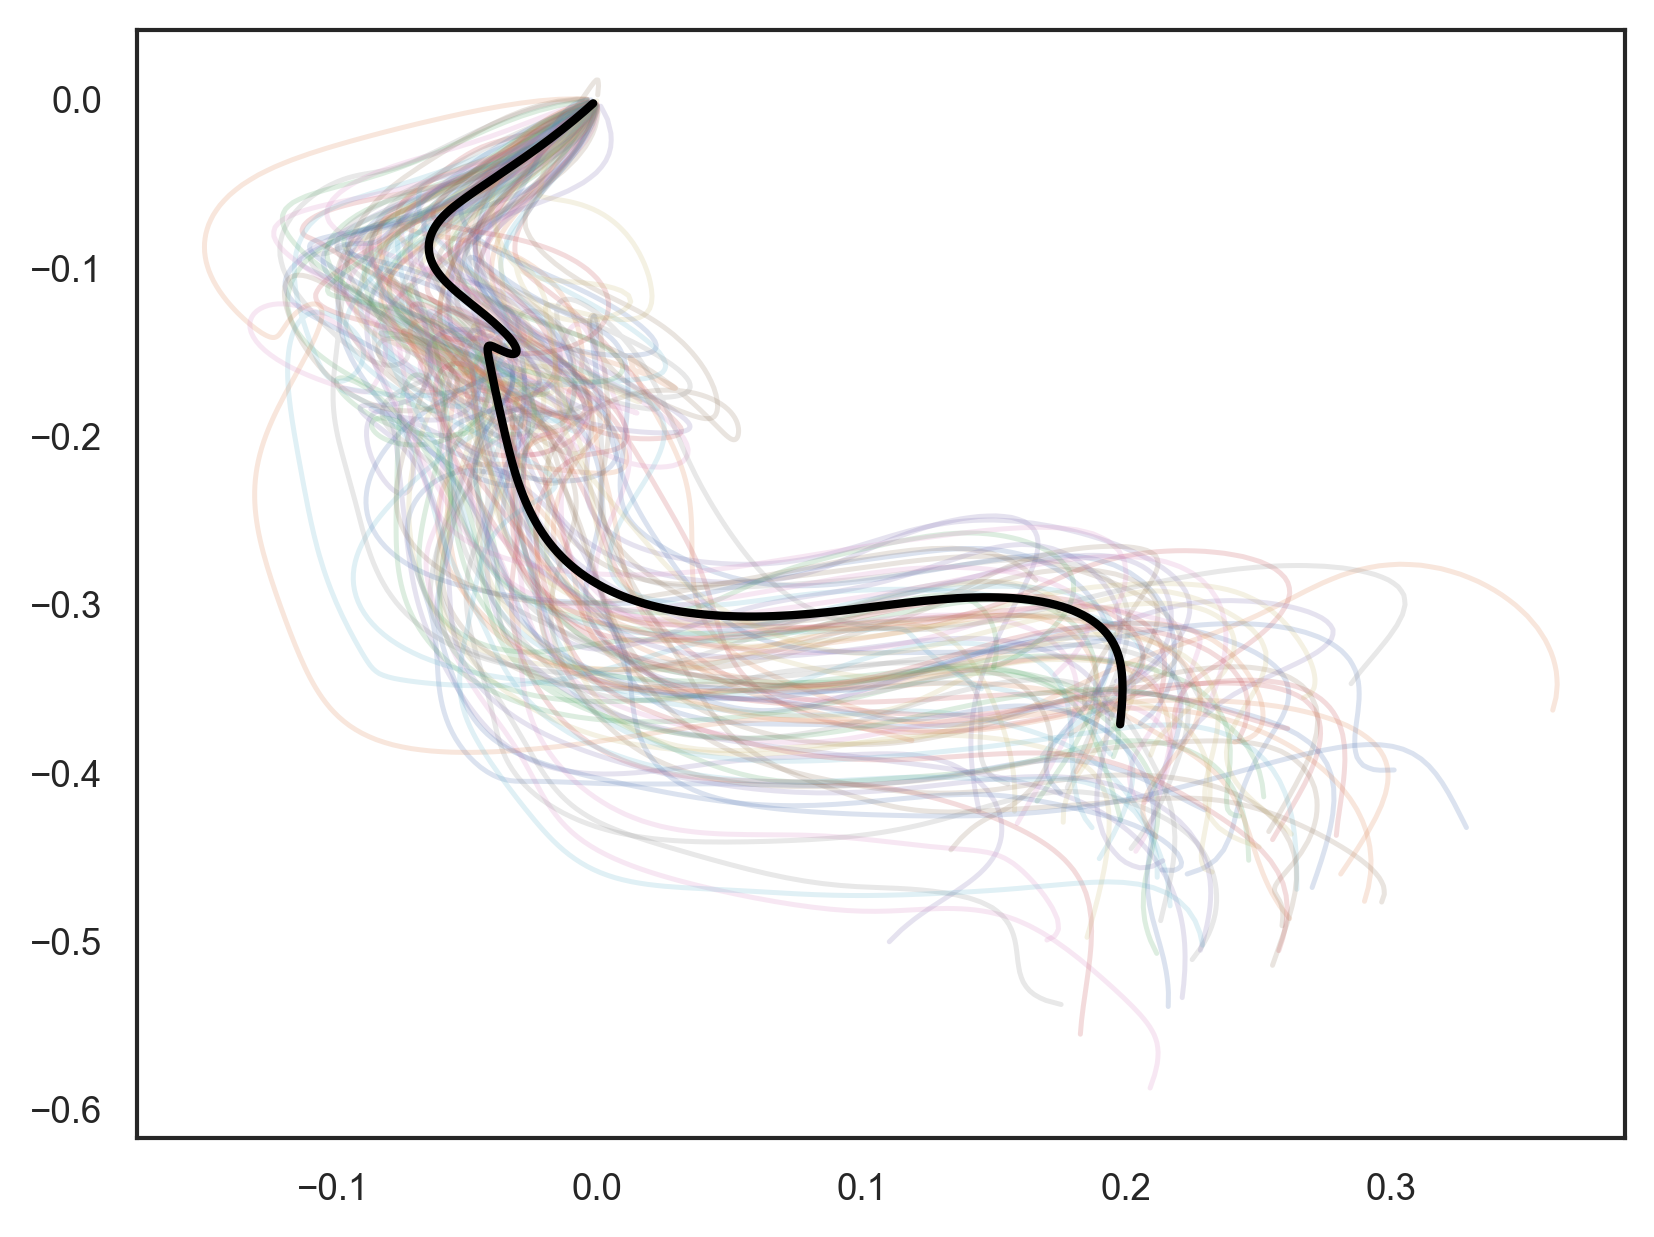

In [52]:
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points+1, equip=False
)
curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)
mean_estimate = mean.estimate_

for i in range(len(curve_cs)):
    plt.plot(curve_cs[i][:, 0], curve_cs[i][:, 1],alpha=0.2)
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], color='black', linewidth=2, label='Frechet Mean')
plt.show()

tPCA_N_COMPONENTS = 16
tangent_base = mean.estimate_

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

In [53]:
print (tpca.explained_variance_)

[0.44654528 0.37268467 0.24390672 0.06284089 0.04124155 0.02884757
 0.02640599 0.01987138 0.01198209 0.01039135 0.006354   0.0059358
 0.00528233 0.00381531 0.00354005 0.00252773]


C:\Users\cheno\AppData\Local\Temp\ipykernel_31064\1028532553.py:20: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.

C:\Users\cheno\AppData\Local\Temp\ipykernel_31064\1028532553.py:35: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



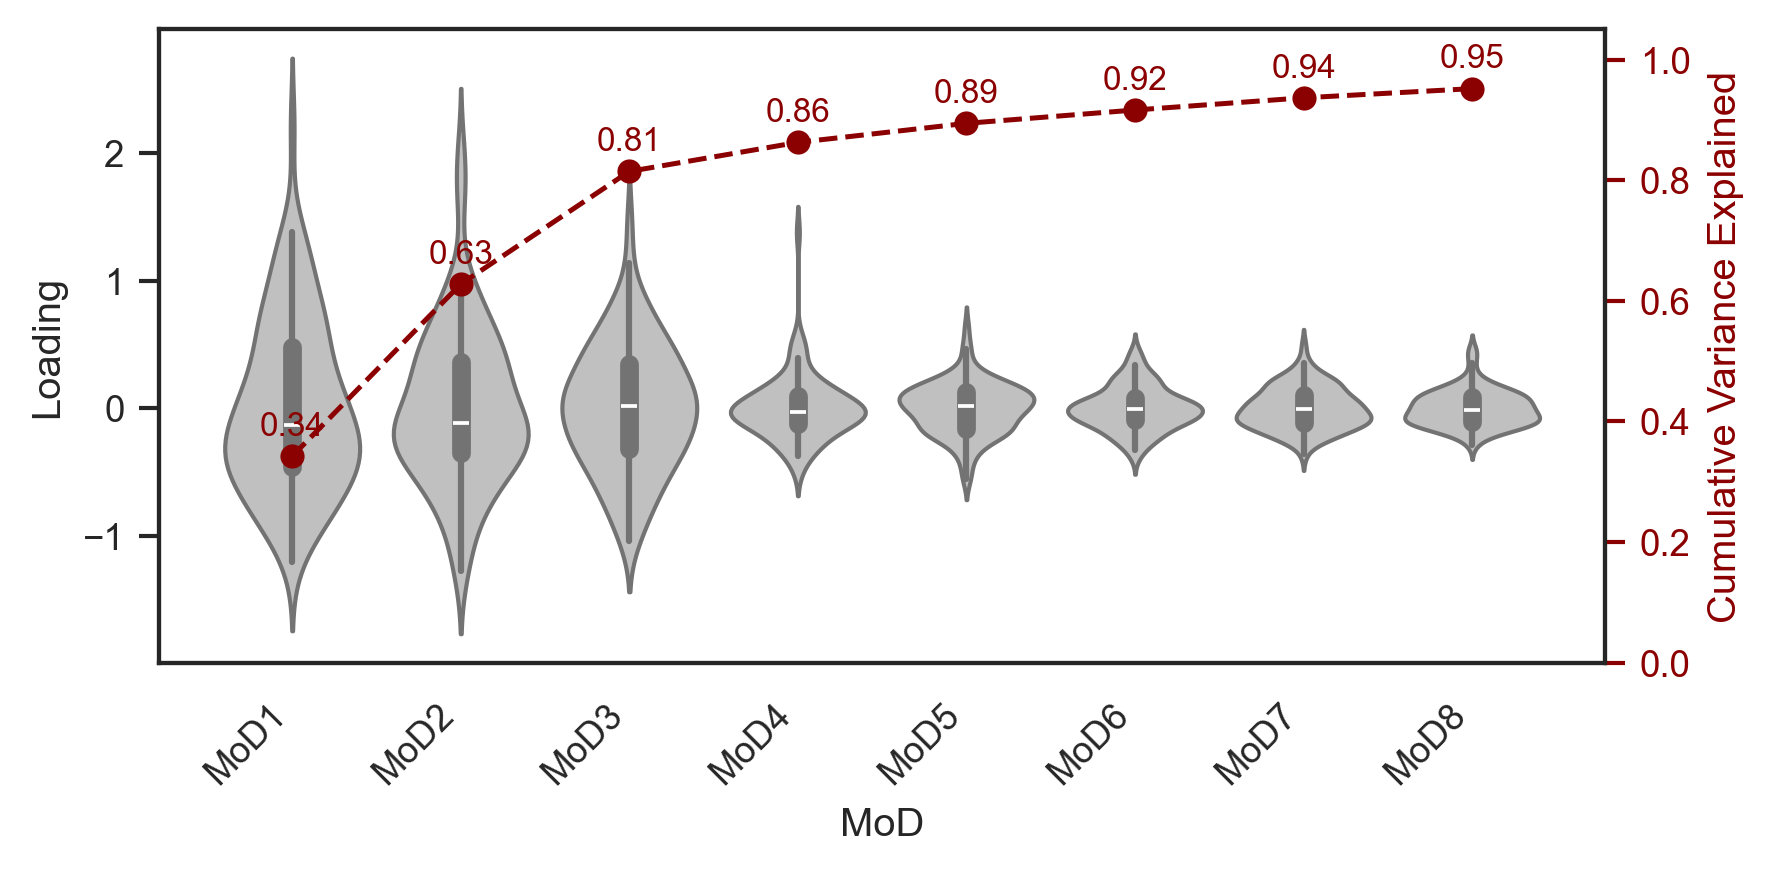

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 预先准备
explained_variance_ratio = tpca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_variance_ratio)
labels_simple = [f"MoD{i+1}" for i in range(len(explained_variance_ratio))]

# 构建DataFrame以便使用seaborn绘图
n_components = tangent_projected_data.shape[1]
df = pd.DataFrame(tangent_projected_data, columns=[f"PC{i+1}" for i in range(n_components)])

# 转换为long-form格式以便violinplot
df_long = df.melt(var_name="MoD", value_name="Loading")

fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)

# 左侧y轴：boxplot
sns.violinplot(
    data=df_long,
    x="MoD",
    y="Loading",
    # inner="quartile",     # 在小提琴内画分位数线
    linewidth=1.0,
    cut=2,                # 不外推数据范围
    scale="width",        # 保持宽度一致
    color="silver",
    ax=ax1
)


ax1.set_xlabel("MoD")
ax1.set_ylabel("Loading")
ax1.set_xticklabels(labels_simple, rotation=45, ha="right")

# 右侧y轴：累计解释率
ax2 = ax1.twinx()
x_vals = np.arange(len(explained_variance_ratio))
ax2.plot(x_vals, cumulative_ratio, color='darkred', marker='o',
         linestyle='--', label='Cumulative Variance')
ax2.set_ylabel("Cumulative Variance Explained", color='darkred')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', colors='darkred')

# === 在点上标注数值 ===
for x, y in zip(x_vals, cumulative_ratio):
    ax2.annotate(f"{y:.2f}",
                 (x, y),
                 textcoords="offset points",
                 xytext=(0, 5),  # 向上偏移5pt
                 ha='center',
                 fontsize=8,
                 color='darkred')

# 可选：去掉多余网格
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


In [21]:
print (list(vtk_data_dict.keys()))

['BG0001_L.vtk', 'BG0001_R.vtk', 'BG0003_L.vtk', 'BG0003_R.vtk', 'BG0004_L.vtk', 'BG0004_R.vtk', 'BG0006_L.vtk', 'BG0006_R.vtk', 'BG0007_L.vtk', 'BG0007_R.vtk', 'BG0008_L.vtk', 'BG0008_R.vtk', 'BG0009_L.vtk', 'BG0009_R.vtk', 'BG0010_L.vtk', 'BG0010_R.vtk', 'BG0011_L.vtk', 'BG0011_R.vtk', 'BG0012_L.vtk', 'BG0012_R.vtk', 'BG0015_L.vtk', 'BG0015_R.vtk', 'BG0017_L.vtk', 'BG0017_R.vtk', 'BG0018_L.vtk', 'BG0018_R.vtk', 'BG0019_L.vtk', 'BG0019_R.vtk', 'BG0020_L.vtk', 'BG0020_R.vtk', 'BG0021_R.vtk', 'BG0022_L.vtk', 'BG0022_R.vtk', 'BG0099_L.vtk', 'BG0099_R.vtk', 'BH0005_L.vtk', 'BH0005_R.vtk', 'BH0006_L.vtk', 'BH0006_R.vtk', 'BH0009_L.vtk', 'BH0009_R.vtk', 'BH0010_L.vtk', 'BH0010_R.vtk', 'BH0011_L.vtk', 'BH0011_R.vtk', 'BH0013_L.vtk', 'BH0013_R.vtk', 'BH0014_L.vtk', 'BH0014_R.vtk', 'BH0016_L.vtk', 'BH0016_R.vtk', 'BH0017_L.vtk', 'BH0017_R.vtk', 'BH0018_L.vtk', 'BH0018_R.vtk', 'BH0019_L.vtk', 'BH0019_R.vtk', 'BH0020_L.vtk', 'BH0020_R.vtk', 'BH0021_L.vtk', 'BH0021_R.vtk', 'BH0022_L.vtk', 'BH0022

In [22]:
def print_structure(d, indent=0):
    pad = "  " * indent
    if isinstance(d, dict):
        print(f"{pad}dict with {len(d)} keys")
        for k, v in d.items():
            print(f"{pad}  {k}: ", end="")
            print_structure(v, indent+1)
    elif isinstance(d, (list, tuple)):
        print(f"{pad}{type(d).__name__} of len {len(d)}")
        if len(d) > 0:
            print_structure(d[0], indent+1)
    else:
        print(f"{pad}{type(d)}")

print_structure(vtk_data_dict)


dict with 91 keys
  BG0001_L.vtk:   dict with 3 keys
    point_data:     dict with 5 keys
      Curvature:       <class 'numpy.ndarray'>
      Torsion:       <class 'numpy.ndarray'>
      FrenetTangent:       <class 'numpy.ndarray'>
      FrenetNormal:       <class 'numpy.ndarray'>
      FrenetBinormal:       <class 'numpy.ndarray'>
    cell_data:     dict with 2 keys
      Length:       <class 'numpy.ndarray'>
      Tortuosity:       <class 'numpy.ndarray'>
    coords:     <class 'numpy.ndarray'>
  BG0001_R.vtk:   dict with 3 keys
    point_data:     dict with 5 keys
      Curvature:       <class 'numpy.ndarray'>
      Torsion:       <class 'numpy.ndarray'>
      FrenetTangent:       <class 'numpy.ndarray'>
      FrenetNormal:       <class 'numpy.ndarray'>
      FrenetBinormal:       <class 'numpy.ndarray'>
    cell_data:     dict with 2 keys
      Length:       <class 'numpy.ndarray'>
      Tortuosity:       <class 'numpy.ndarray'>
    coords:     <class 'numpy.ndarray'>
  BG0003_L.v

In [23]:
import plotly.express as px
import pandas as pd

# 假设 tangent_projected_data 和 vtk_data_dict 是一一对应的
keys = list(vtk_data_dict.keys())

# 从 sub-dict 里提取 Tortuosity（示例取 cell_data['Tortuosity'] 的均值）
tortuosity_vals = [
    sub["cell_data"]["Tortuosity"].mean() if "cell_data" in sub else None
    for sub in vtk_data_dict.values()
]

# 构建 DataFrame
df = pd.DataFrame({
    "Key": keys,
    "MoD1": tangent_projected_data[:, 0],
    "MoD2": tangent_projected_data[:, 1],
    "MoD3": tangent_projected_data[:, 2],
    "Tortuosity": tortuosity_vals
})

# 绘制 3D 散点图，hover 可以显示 Key 和 Tortuosity
fig = px.scatter_3d(
    df,
    x="MoD1",
    y="MoD2",
    z="MoD3",
    color="Tortuosity",  # 颜色映射到 Tortuosity
    hover_data=["Key", "Tortuosity"],
    opacity=0.7
)

fig.update_traces(
    marker=dict(size=5, line=dict(width=1, color="black"))
)

fig.update_layout(
    scene=dict(
        xaxis_title="MoD1",
        yaxis_title="MoD2",
        zaxis_title="MoD3"
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    font=dict(family="Times New Roman", size=16)
)

fig.show()


In [24]:
# import numpy as np
# import matplotlib.pyplot as plt
# from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
# from geomstats.learning.frechet_mean import FrechetMean

# # 参数设定
# pc_index = 0
# scores = tangent_projected_data[:, pc_index]
# threshold = np.median(scores)

# # 根据 PC1 分组
# high_group = curve_cs[scores > threshold]
# low_group = curve_cs[scores <= threshold]

# # 分别构建 manifold 对象（每组要单独构建，因为 manifold 中缓存了采样点数）
# curves_r3_pc1_high = DiscreteCurvesStartingAtOrigin(
#     ambient_dim=3, k_sampling_points=high_group.shape[1], equip=False
# )
# curves_r3_pc1_high.equip_with_metric(SRVMetric)

# curves_r3_pc1_low = DiscreteCurvesStartingAtOrigin(
#     ambient_dim=3, k_sampling_points=low_group.shape[1], equip=False
# )
# curves_r3_pc1_low.equip_with_metric(SRVMetric)

# # 分别计算 Frechet Mean
# mean_high = FrechetMean(curves_r3_pc1_high)
# mean_high.fit(high_group)
# mean_high_curve = mean_high.estimate_

# mean_low = FrechetMean(curves_r3_pc1_low)
# mean_low.fit(low_group)
# mean_low_curve = mean_low.estimate_


# diff = mean_high_curve - mean_low_curve
# euclidean_diff_norm = np.linalg.norm(diff, axis=1)
# total_diff = np.sum(euclidean_diff_norm) / len(euclidean_diff_norm)
# print(f"Average Euclidean norm between mean curves: {total_diff:.6f}")

# pca = PCA(n_components=3)
# pca.fit(diff)

# print("Explained variance ratio (directionality of shape change):", pca.explained_variance_ratio_)
# print("Principal direction of shape difference (1st PC):", pca.components_[0])

# import numpy as np
# import plotly.graph_objects as go
# from sklearn.decomposition import PCA

# # 计算差值和主方向
# diff = mean_high_curve - mean_low_curve
# pca = PCA(n_components=3)
# pca.fit(diff)
# principal_direction = pca.components_[0]  # shape: (3,)

# # 设置箭头的起点为 mean_low_curve 的中点
# center_idx = len(mean_low_curve) // 2
# arrow_start = mean_low_curve[center_idx]
# arrow_dir = principal_direction * 0.1  # 调整长度以便可视化
# arrow_end = arrow_start + arrow_dir

# # 创建图形
# fig = go.Figure()

# # 添加平均曲线
# fig.add_trace(go.Scatter3d(
#     x=mean_low_curve[:, 0], y=mean_low_curve[:, 1], z=mean_low_curve[:, 2],
#     mode='lines',
#     name='Low PC1',
#     line=dict(color='blue')
# ))

# fig.add_trace(go.Scatter3d(
#     x=mean_high_curve[:, 0], y=mean_high_curve[:, 1], z=mean_high_curve[:, 2],
#     mode='lines',
#     name='High PC1',
#     line=dict(color='red')
# ))

# # 添加主方向箭头
# fig.add_trace(go.Scatter3d(
#     x=[arrow_start[0], arrow_end[0]],
#     y=[arrow_start[1], arrow_end[1]],
#     z=[arrow_start[2], arrow_end[2]],
#     mode='lines+markers',
#     name='Principal Direction',
#     line=dict(color='black', width=6, dash='dot'),
#     marker=dict(size=3, color='black')
# ))

# fig.update_layout(
#     title='PC1 Effect: High vs Low group with Principal Direction',
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z'
#     ),
#     width=800,
#     height=600
# )

# fig.show()



In [25]:
import numpy as np
import random
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
from geomstats.learning.frechet_mean import FrechetMean
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# 保证结果可复现
random.seed(42)

def compute_mean_curve(curves_group):
    """在 SRV 流形上计算 Frechet Mean 曲线"""
    manifold = DiscreteCurvesStartingAtOrigin(
        ambient_dim=3,
        k_sampling_points=curves_group.shape[1],
        equip=False
    )
    manifold.equip_with_metric(SRVMetric)
    mean_estimator = FrechetMean(manifold)
    mean_estimator.fit(curves_group)
    return mean_estimator.estimate_

def plot_pc_effect(pc_index, tangent_projected_data, curve_cs, n_examples=5):
    """绘制指定主成分的高低组曲线及差异主方向"""
    scores = tangent_projected_data[:, pc_index]
    threshold = np.median(scores)

    high_group = curve_cs[scores > threshold]
    low_group = curve_cs[scores <= threshold]

    # 随机抽取样例
    high_examples = high_group[np.random.choice(len(high_group), n_examples, replace=False)]
    low_examples = low_group[np.random.choice(len(low_group), n_examples, replace=False)]

    # Frechet Mean
    mean_high_curve = compute_mean_curve(high_group)
    mean_low_curve = compute_mean_curve(low_group)

    # 差异 & PCA
    diff = mean_high_curve - mean_low_curve
    pca = PCA(n_components=3)
    pca.fit(diff)
    principal_direction = pca.components_[0]

    # 箭头起点设为 mean_low_curve 中点
    center_idx = len(mean_low_curve) // 2
    arrow_start = mean_low_curve[center_idx]
    arrow_end = arrow_start + principal_direction * 0.1

    # ==== 可视化 ====
    fig = go.Figure()

    # 样例曲线
    for ex in low_examples:
        fig.add_trace(go.Scatter3d(
            x=ex[:, 0], y=ex[:, 1], z=ex[:, 2],
            mode='lines',
            line=dict(color='blue', width=1, dash='dot'),
            name='Low Example',
            showlegend=False
        ))
    for ex in high_examples:
        fig.add_trace(go.Scatter3d(
            x=ex[:, 0], y=ex[:, 1], z=ex[:, 2],
            mode='lines',
            line=dict(color='red', width=1, dash='dot'),
            name='High Example',
            showlegend=False
        ))

    # Frechet Mean 曲线
    fig.add_trace(go.Scatter3d(
        x=mean_low_curve[:, 0], y=mean_low_curve[:, 1], z=mean_low_curve[:, 2],
        mode='lines',
        name='Low Mean',
        line=dict(color='blue', width=4)
    ))
    fig.add_trace(go.Scatter3d(
        x=mean_high_curve[:, 0], y=mean_high_curve[:, 1], z=mean_high_curve[:, 2],
        mode='lines',
        name='High Mean',
        line=dict(color='red', width=4)
    ))

    # 主方向箭头
    fig.add_trace(go.Scatter3d(
        x=[arrow_start[0], arrow_end[0]],
        y=[arrow_start[1], arrow_end[1]],
        z=[arrow_start[2], arrow_end[2]],
        mode='lines+markers',
        name='Principal Direction',
        line=dict(color='black', width=6, dash='dot'),
        marker=dict(size=3, color='black')
    ))

    fig.update_layout(
        title=f'PC{pc_index+1} Effect: High vs Low Group',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=800,
        height=600
    )

    fig.show()
    return fig

# ==== 循环绘制 PC1, PC2, PC3 ====
for pc in range(3):
    plot_pc_effect(pc, tangent_projected_data, curve_cs, n_examples=5)


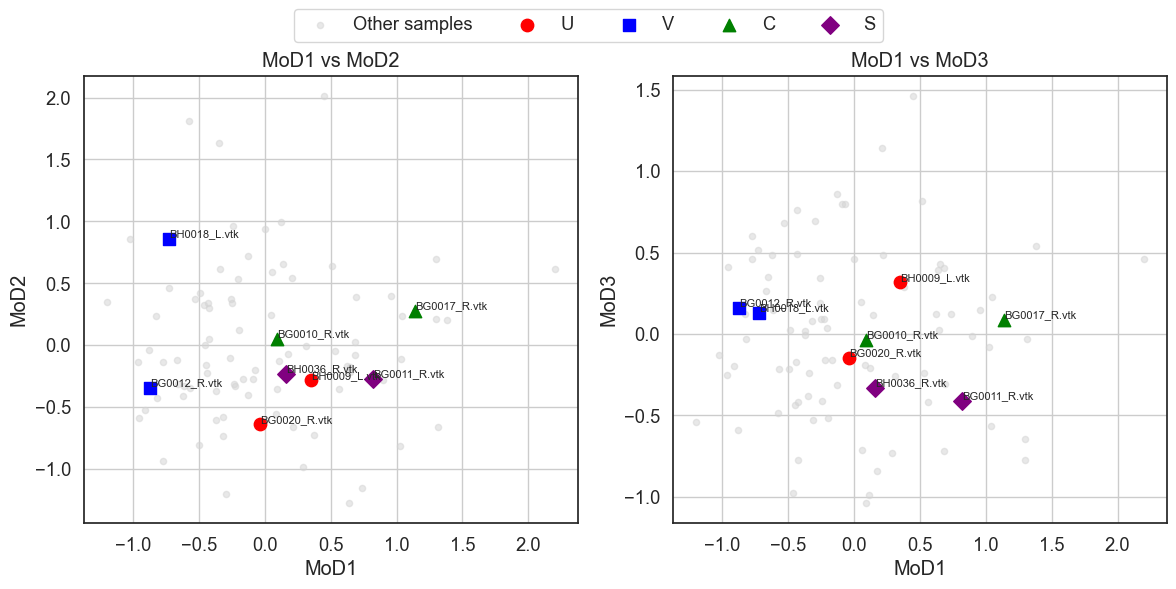

In [26]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# === 1. 高亮 BG0019_L.vtk 在散点图中 ===
keys = list(vtk_data_dict.keys())

df = pd.DataFrame({
    "Key": keys,
    "MoD1": tangent_projected_data[:, 0],
    "MoD2": tangent_projected_data[:, 1],
    "MoD3": tangent_projected_data[:, 2],
})

# target_key = "BG0020_R.vtk"

# U:BG0020_R/BH0009_L 
# V:BG0012_R/BH0018_L 
# C:BG0017_R/BH0010_R 
# S:BG0011_R/BH0036_R


# 定义四类的 key
groups = {
    "U": ["BG0020_R.vtk", "BH0009_L.vtk"],
    "V": ["BG0012_R.vtk", "BH0018_L.vtk"],
    "C": ["BG0017_R.vtk", "BG0010_R.vtk"],
    "S": ["BG0011_R.vtk", "BH0036_R.vtk"],
}

# 给每个 type 指定颜色和 marker
styles = {
    "U": dict(color="red", marker="o"),
    "V": dict(color="blue", marker="s"),
    "C": dict(color="green", marker="^"),
    "S": dict(color="purple", marker="D"),
}



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# -------- 子图 1: MoD1 vs MoD2 --------
ax = axes[0]
ax.scatter(df["MoD1"], df["MoD2"], c="lightgray", s=20, alpha=0.5, label="Other samples")

for g, keys in groups.items():
    rows = df[df["Key"].isin(keys)]
    ax.scatter(rows["MoD1"], rows["MoD2"],
               s=80,
               label=g,
               **styles[g])
    for _, row in rows.iterrows():
        ax.text(row["MoD1"], row["MoD2"], row["Key"],
                fontsize=8, ha="left", va="bottom")

ax.set_xlabel("MoD1")
ax.set_ylabel("MoD2")
ax.set_title("MoD1 vs MoD2")
ax.grid(True)

# -------- 子图 2: MoD1 vs MoD3 --------
ax = axes[1]
ax.scatter(df["MoD1"], df["MoD3"], c="lightgray", s=20, alpha=0.5, label="Other samples")

for g, keys in groups.items():
    rows = df[df["Key"].isin(keys)]
    ax.scatter(rows["MoD1"], rows["MoD3"],
               s=80,
               label=g,
               **styles[g])
    for _, row in rows.iterrows():
        ax.text(row["MoD1"], row["MoD3"], row["Key"],
                fontsize=8, ha="left", va="bottom")

ax.set_xlabel("MoD1")
ax.set_ylabel("MoD3")
ax.set_title("MoD1 vs MoD3")
ax.grid(True)

# -------- 公共设置 --------
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5)
# plt.suptitle("Highlighted 8 samples by type", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


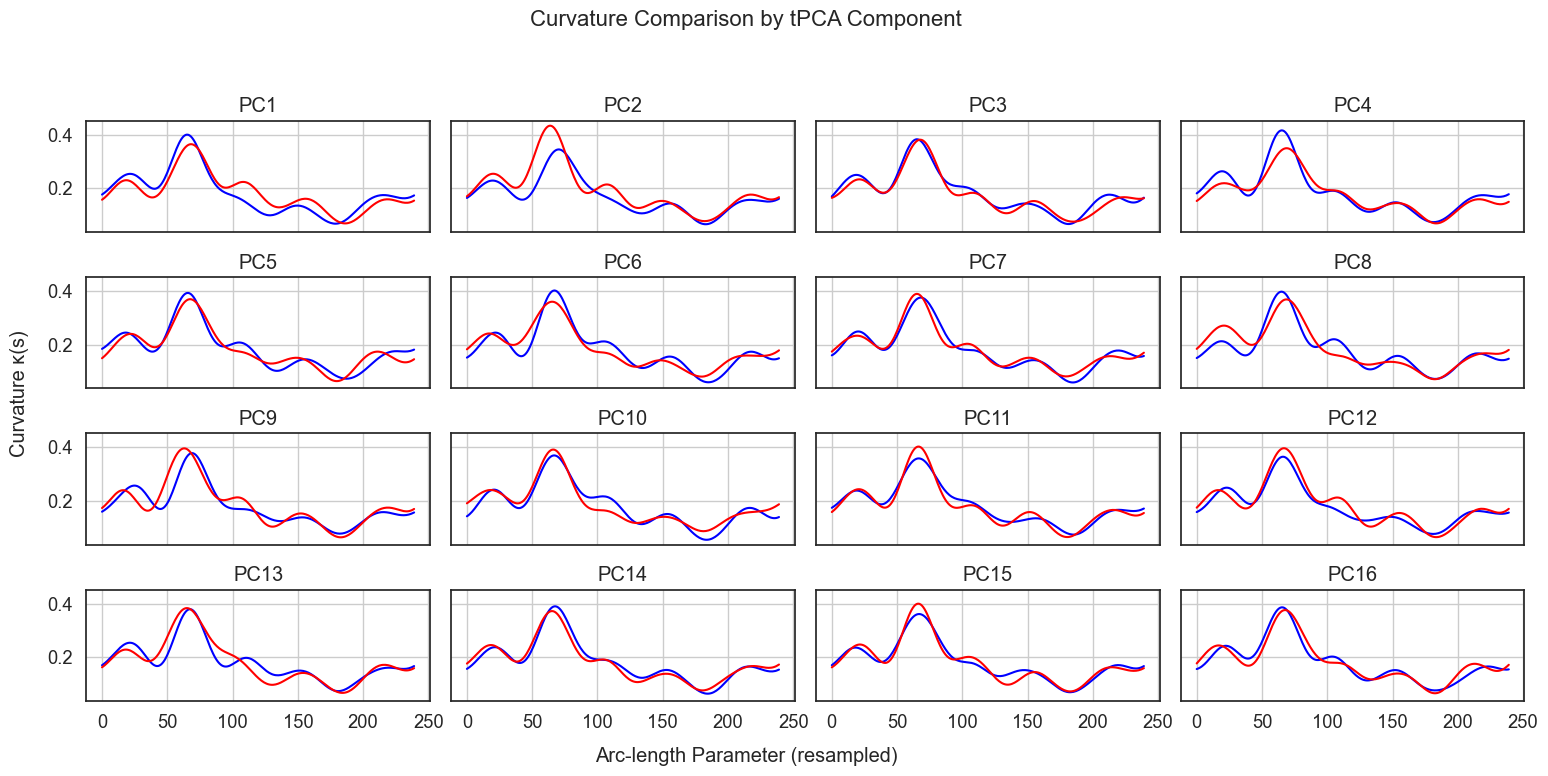

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 参数
n_components = 16  # 总主成分数
n_cols = 4         # 每行放几个子图
n_rows = int(np.ceil(n_components / n_cols))  # 自动计算行数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]

    scores = tangent_projected_data[:, pc_index]
    threshold = np.median(scores)

    high_idx = scores > threshold
    low_idx = scores <= threshold

    mean_kappa_high_aligned = np.mean(f_weighted_unwrapped[:, high_idx], axis=1)
    mean_kappa_low_aligned = np.mean(f_weighted_unwrapped[:, low_idx], axis=1)
    mean_kappa_high = np.mean(np.array(resampled_curves)[high_idx, :], axis=0)
    mean_kappa_low = np.mean(np.array(resampled_curves)[low_idx, :], axis=0)

    ax.plot(mean_kappa_low, label='Low', color='blue')
    ax.plot(mean_kappa_high, label='High', color='red')
    # ax.plot(mean_kappa_high_aligned, label='High (Aligned)', color='red', linestyle='--')
    # ax.plot(mean_kappa_low_aligned, label='Low (Aligned)', color='blue', linestyle='--')
    ax.set_title(f'PC{pc_index + 1}')
    ax.grid(True)

# 去除多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

# 统一标签与布局
fig.suptitle('Curvature Comparison by tPCA Component', fontsize=16)
fig.text(0.5, 0.04, 'Arc-length Parameter (resampled)', ha='center')
fig.text(0.04, 0.5, 'Curvature κ(s)', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()


In [28]:
print (np.array(resampled_curves).shape)

(91, 240)


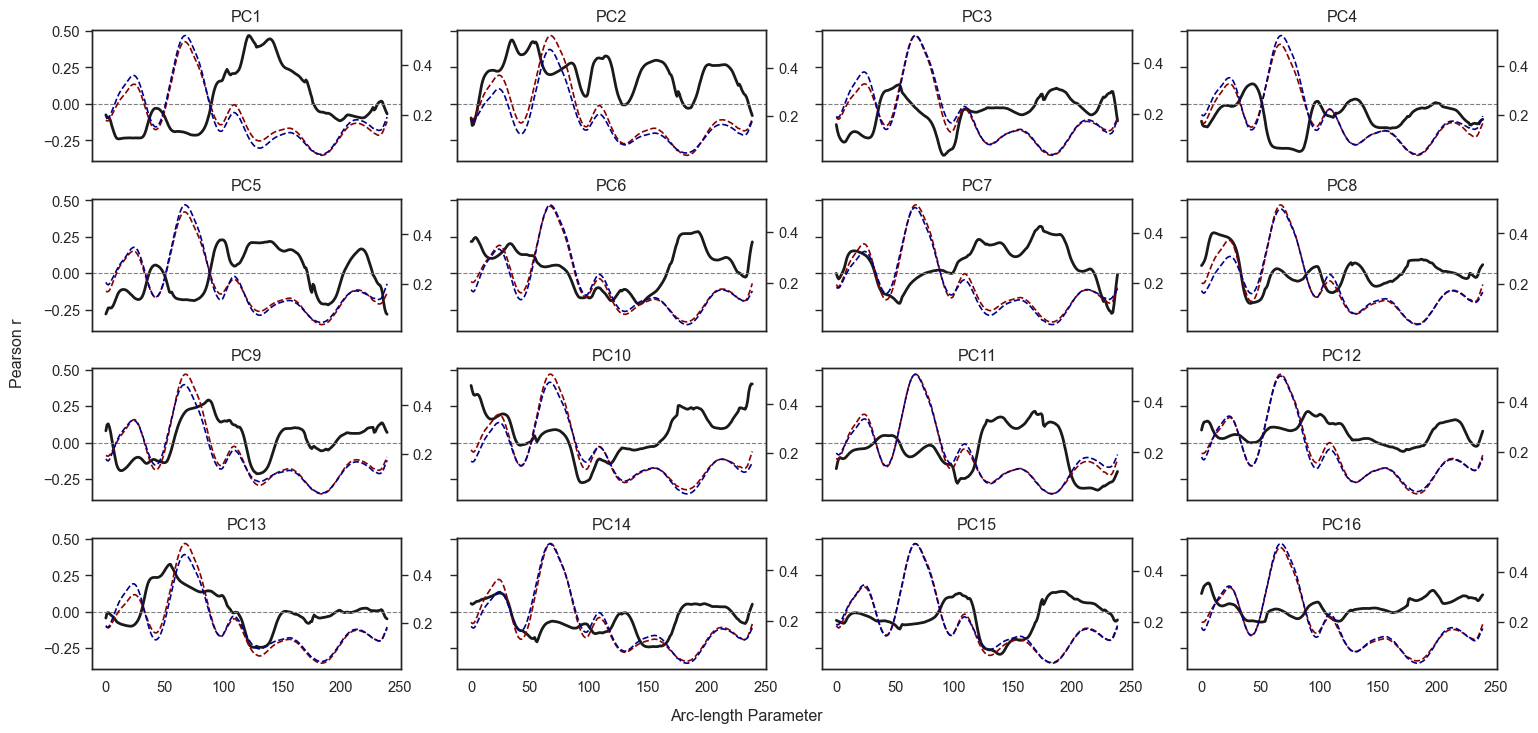

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr


sns.set(style="white", context="paper", font_scale=1.2)
# 参数
n_components = 16
n_cols = 4
n_rows = int(np.ceil(n_components / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]
    pc_scores = tangent_projected_data[:, pc_index]

    # scores = tangent_projected_data[:, pc_index]
    threshold = np.median(pc_scores)

    high_idx = pc_scores > threshold
    low_idx = pc_scores <= threshold
    # print (f"PC{pc_index + 1}: High group size = {np.sum(high_idx)}, Low group size = {np.sum(low_idx)}")

    mean_kappa_high_aligned = np.mean(f_weighted_unwrapped[:, high_idx], axis=1)
    mean_kappa_low_aligned = np.mean(f_weighted_unwrapped[:, low_idx], axis=1)

    corrs = []
    for j in range(f_weighted_unwrapped.shape[0]):
        r, _ = pearsonr(pc_scores, f_weighted_unwrapped[j, :])
        corrs.append(r)

    corrs = np.array(corrs)

    ax.plot(corrs, color='k',linewidth=2, label='PC Score Correlation')

    ax_2 = ax.twinx()
    ax_2.plot(mean_kappa_high_aligned, color='darkred', linestyle='--', label='High (Aligned)')
    ax_2.plot(mean_kappa_low_aligned, color='darkblue', linestyle='--', label='Low (Aligned)')

    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)
    ax.set_title(f'PC{pc_index + 1}')
    ax.grid(False)
    ax_2.grid(False)

# 去除多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

# 总体标签与布局
# fig.suptitle('Pointwise Correlation: Curvature vs. tPCA Components', fontsize=16)
fig.text(0.5, 0.04, 'Arc-length Parameter', ha='center')
fig.text(0.04, 0.5, 'Pearson r', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()


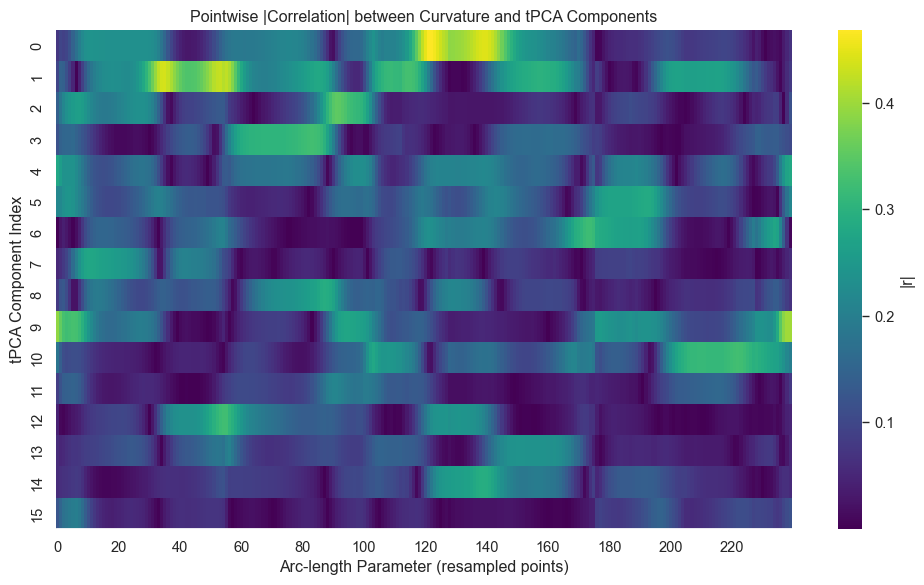

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# Step 1: 构建相关矩阵 R (n_points, n_components)
n_components = tangent_projected_data.shape[1]
n_points = f_weighted_unwrapped.shape[0]
R = np.zeros((n_points, n_components))

for pc_index in range(n_components):
    pc_scores = tangent_projected_data[:, pc_index]
    for j in range(n_points):
        r, _ = pearsonr(pc_scores, f_weighted_unwrapped[j, :])
        R[j, pc_index] = r

# Step 2: 计算每个点的影响模式
# 模式强度特征
abs_R = np.abs(R)
max_r = np.max(abs_R, axis=1)
mean_r = np.mean(abs_R, axis=1)
std_r = np.std(abs_R, axis=1)


# Step 4: 可视化热图
plt.figure(figsize=(10, 6))
sns.heatmap(abs_R.T, cmap='viridis', cbar_kws={'label': '|r|'}, xticklabels=20)
plt.axhline(y=n_components, color='white', linewidth=2)
plt.xlabel("Arc-length Parameter (resampled points)")
plt.ylabel("tPCA Component Index")
plt.title("Pointwise |Correlation| between Curvature and tPCA Components")
plt.tight_layout()
plt.show()


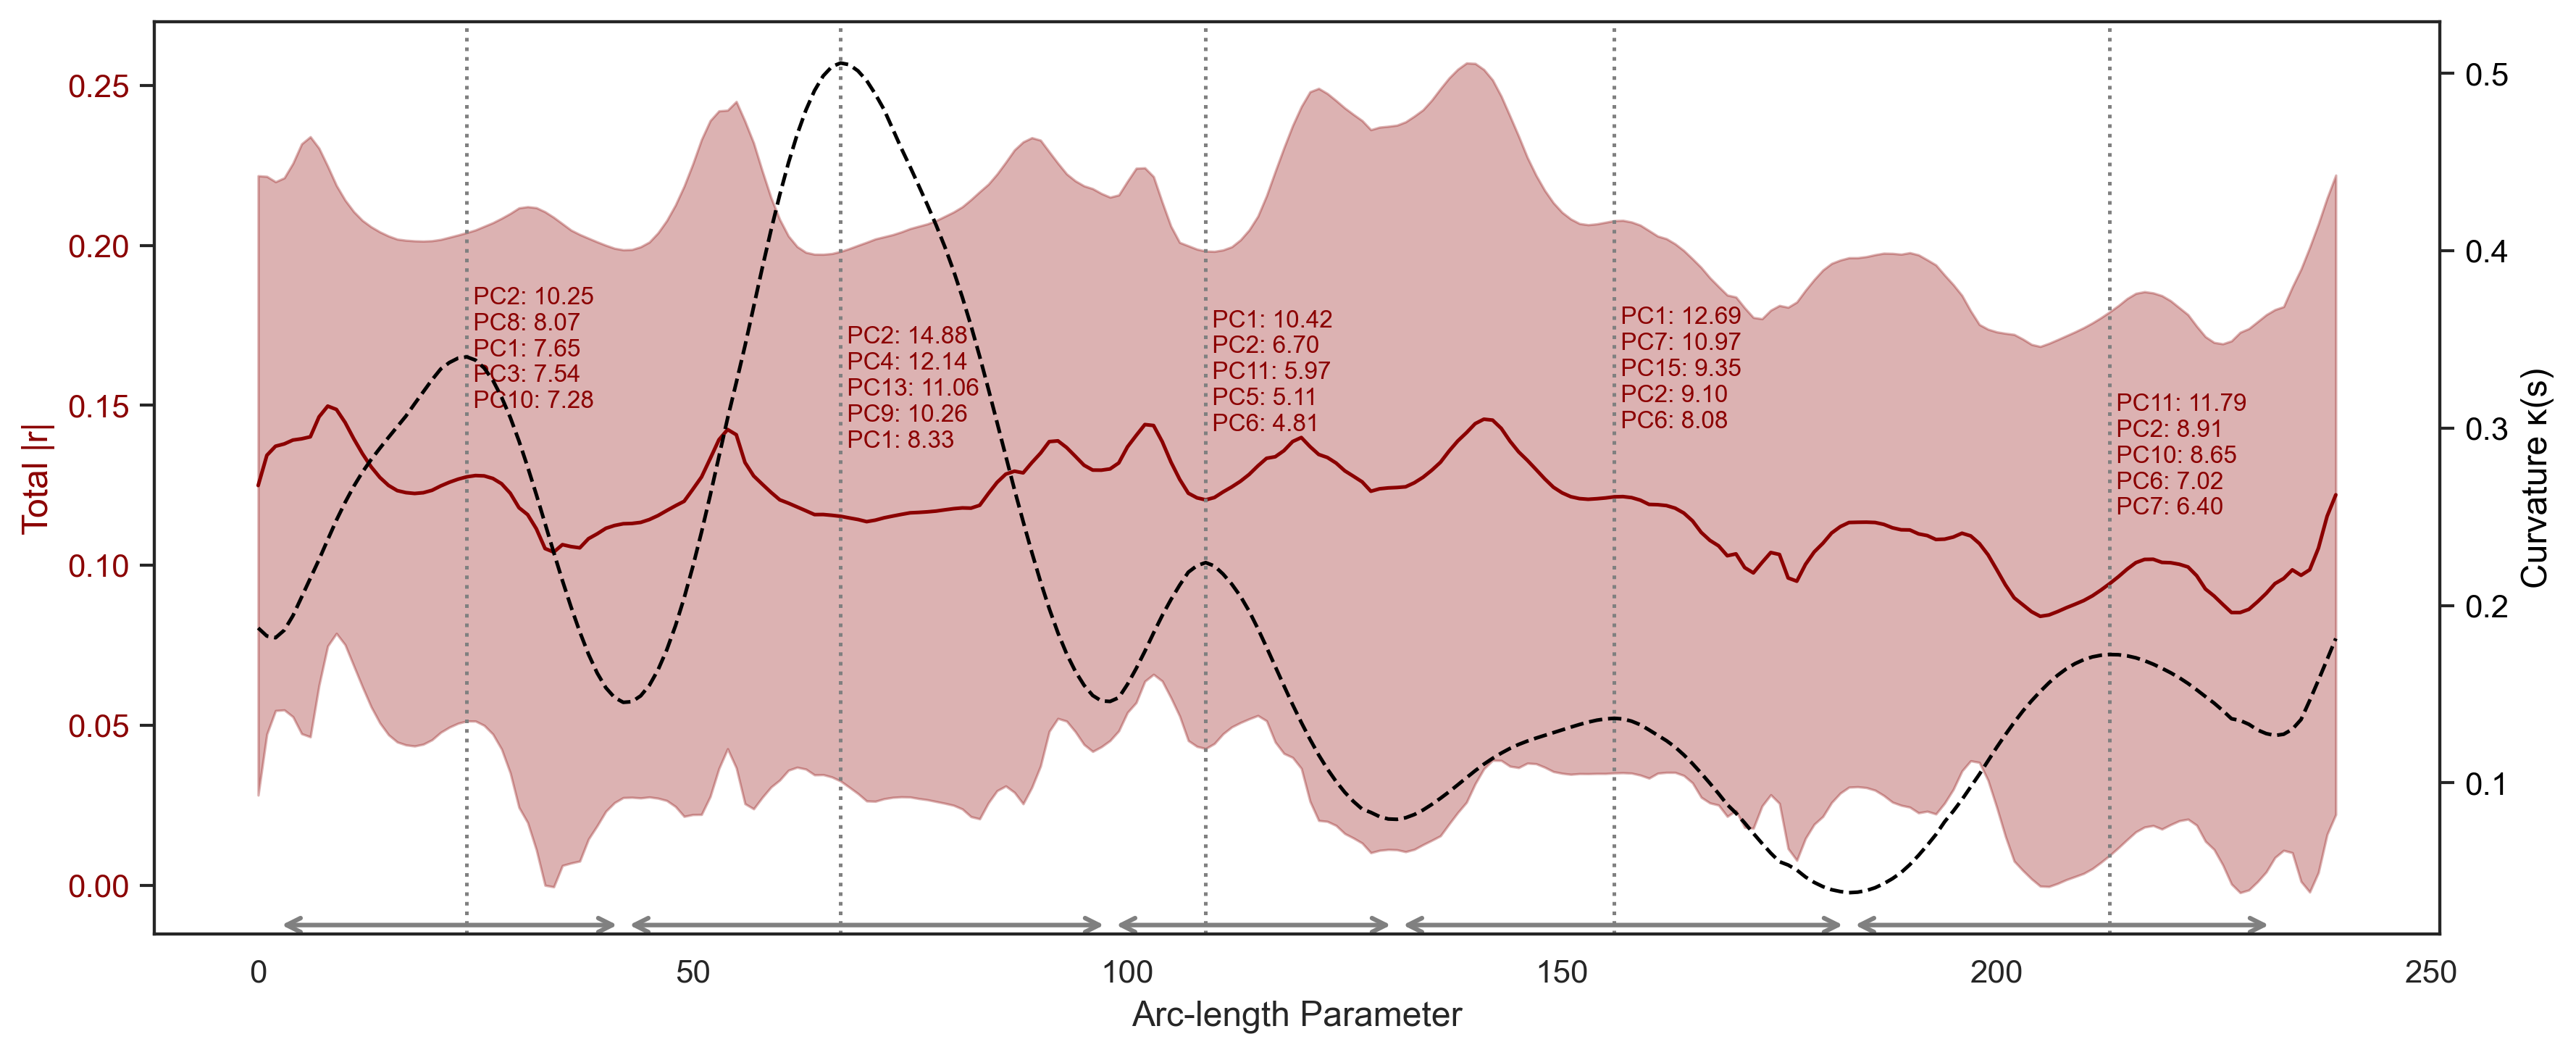

In [31]:
from scipy.signal import find_peaks

# Step 5: 计算每个点的整体影响强度
influence_score = np.sum(abs_R, axis=1) / tPCA_N_COMPONENTS
influence_std = np.std(abs_R, axis=1)

# Step 6: 计算平均曲率并找出波峰与波谷
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)
valleys, _ = find_peaks(-mean_curvature, distance=5)

# Step 7: 对每个波峰，在其相邻波谷范围内整合abs_R
topk = 5
top_tpcs = []
top_vals = []

for peak in peaks:
    # 找左波谷：小于当前peak的最大valley
    left_valley_candidates = valleys[valleys < peak]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0

    # 找右波谷：大于当前peak的最小valley
    right_valley_candidates = valleys[valleys > peak]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R.shape[0] - 1

    # 在区间 [left, right] 内对每个tPC累加影响
    region_r = abs_R[left:right + 1, :]  # shape: (region_len, n_components)
    summed_r = np.sum(region_r, axis=0)  # shape: (n_components,)

    # 找出 top-k tPC
    top_pc_indices = np.argsort(summed_r)[-topk:][::-1]
    top_pc_values = summed_r[top_pc_indices]

    top_tpcs.append(top_pc_indices)
    top_vals.append(top_pc_values)

top_tpcs = np.array(top_tpcs)
top_vals = np.array(top_vals)

# 可视化
fig = plt.figure(figsize=(12, 5),dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(
    x,
    influence_score - influence_std,
    influence_score + influence_std,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

ax2.plot(mean_curvature, color='black', linestyle='--', label='Mean κ(s)')

# 标注每个峰值区间的前5个影响最大tPC及其影响值
for i, idx in enumerate(peaks):
    # 取出区间左右边界
    left_valley_candidates = valleys[valleys < idx]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0
    right_valley_candidates = valleys[valleys > idx]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R.shape[0] - 1

    # 竖线标注峰值
    ax1.axvline(idx, color='gray', linestyle=':', alpha=1)

    # 箭头/横线：从 left 到 right，紧贴 x 轴底部
    y_arrow = ax1.get_ylim()[0] + 0.01 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    ax1.annotate('', xy=(right, y_arrow), xytext=(left, y_arrow),
                 arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5), annotation_clip=False)

    # 文字标注
    label_text = '\n'.join([f" PC{pc+1}: {val:.2f}" for pc, val in zip(top_tpcs[i], top_vals[i])])
    ax1.text(idx, influence_score[idx] + 0.02, label_text,
             color='darkred', fontsize=8, ha='left', va='bottom')

# 图美化
ax1.set_xlabel("Arc-length Parameter")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Curvature κ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()


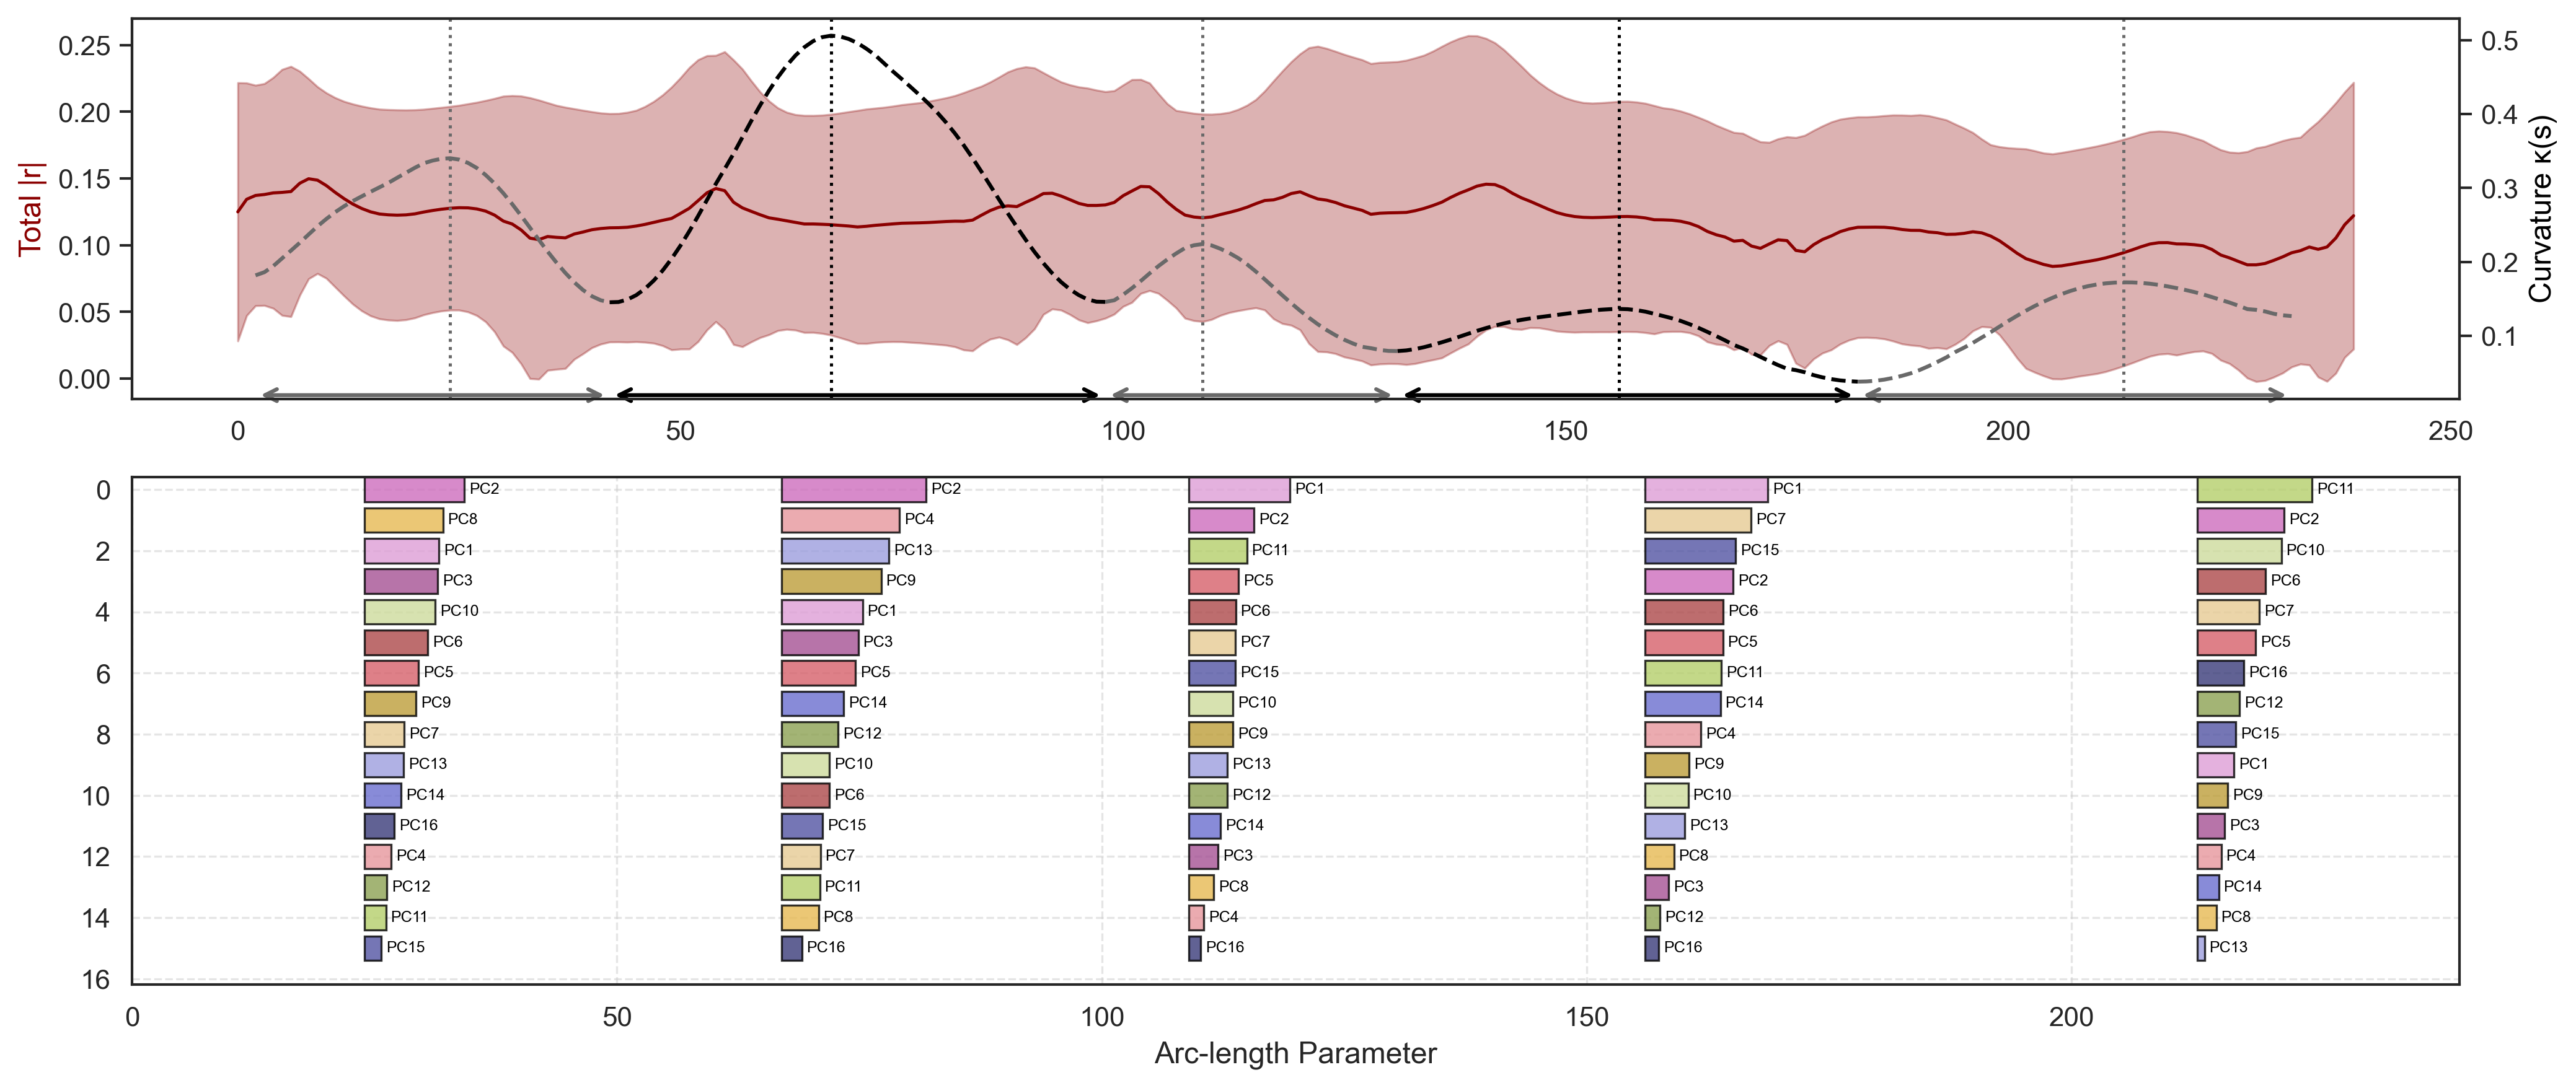

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, entropy
from scipy.signal import find_peaks

# 假设你已有：
# abs_R: shape (n_points, n_components)
# f_weighted_unwrapped: curvature matrix
# influence_score, influence_std
sns.set_context('paper' , font_scale=1.2)
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)
valleys, _ = find_peaks(-mean_curvature, distance=5)

interval_contribs = []
interval_zscores = []
interval_entropy = []
interval_bounds = []
interval_centers = []

for idx in peaks:
    left = valleys[valleys < idx][-1] if np.any(valleys < idx) else 0
    right = valleys[valleys > idx][0] if np.any(valleys > idx) else abs_R.shape[0] - 1
    region_r = abs_R[left:right + 1, :]
    summed_r = np.sum(region_r, axis=0)
    z = zscore(summed_r)
    e = entropy(summed_r / np.sum(summed_r))

    interval_contribs.append(summed_r)
    interval_zscores.append(z)
    interval_entropy.append(e)
    interval_bounds.append((left, right))
    interval_centers.append(idx)

interval_contribs = np.array(interval_contribs)       # (n_peaks, n_components)
interval_zscores = np.array(interval_zscores)         # (n_peaks, n_components)
interval_entropy = np.array(interval_entropy)         # (n_peaks,)
interval_centers = np.array(interval_centers)         # (n_peaks,)
n_components = abs_R.shape[1]

# 可视化
fig = plt.figure(figsize=(14, 6), dpi=300)
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, n_components / 6])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# 上图：influence + curvature + entropy + 区间箭头
x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(x, influence_score - influence_std, influence_score + influence_std,
                 color='darkred', alpha=0.3)
ax1_2 = ax1.twinx()
# ax1_2.plot(mean_curvature, color='black', linestyle='--', label='Mean κ(s)')
# 给每个区间分配颜色（从 tab10 colormap 中取）

interval_colors = ['dimgray', 'black']  # 两种颜色交替

for i, (left, right) in enumerate(interval_bounds):
    ax1_2.plot(np.arange(left, right + 1), mean_curvature[left:right + 1],
               linestyle='--', color=interval_colors[i % 2], linewidth=1.5)

for i, idx in enumerate(interval_centers):
    left, right = interval_bounds[i]
    color = interval_colors[i % 2]
    
    ax1.axvline(idx, color=color, linestyle=':', alpha=1)
    y_arrow = ax1.get_ylim()[0] + 0.01 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    ax1.annotate('', xy=(right, y_arrow), xytext=(left, y_arrow),
                 arrowprops=dict(arrowstyle='<->', color=color, lw=1.5), annotation_clip=False)


ax1.set_ylabel("Total |r|", color='darkred')
ax1_2.set_ylabel("Curvature κ(s)", color='black')

# 下图：每个峰值一列，按照贡献从大到小排列的横向条形图（每行为一个rank）
bar_width = 0.8
colors = plt.cm.tab20b_r(np.linspace(0, 1, n_components))
pc_color_map = {pc: colors[pc] for pc in range(n_components)}

for peak_idx, center in enumerate(interval_centers):
    contribs = interval_contribs[peak_idx]
    sorted_indices = np.argsort(contribs)[::-1]  # 降序排列

    for rank, pc in enumerate(sorted_indices):
        width = contribs[pc]
        ax2.bar(x=center, height=bar_width, width=width,
                bottom=rank - bar_width / 2,
                color=pc_color_map[pc], alpha=0.8, align='edge', edgecolor='black')

        ax2.text(center + width + 0.5, rank, f"PC{pc+1}",
                 fontsize=6, color='black', va='center')

# ax2.set_yticks(np.arange(n_components))
# ax2.set_yticklabels([f"Rank {i+1}" for i in range(n_components)])
ax2.set_xlim(0, len(influence_score))
ax2.set_xlabel("Arc-length Parameter")
ax2.invert_yaxis()
ax1.grid(False)
ax1_2.grid(False)
ax2.grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()
plt.show()


Identified 5 peaks (C0 ~ C4)
C1 Index: 67, C1 Time (normalized): 0.2803


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



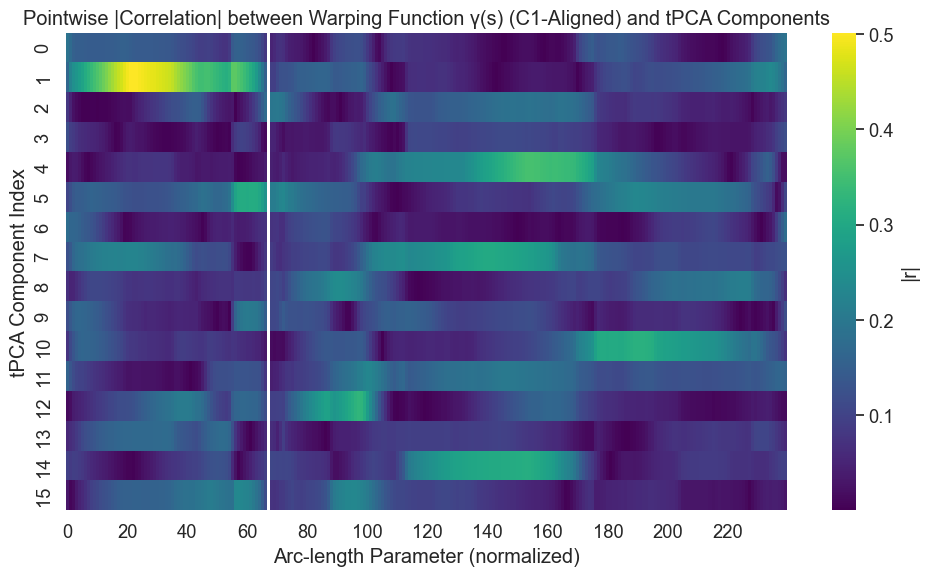

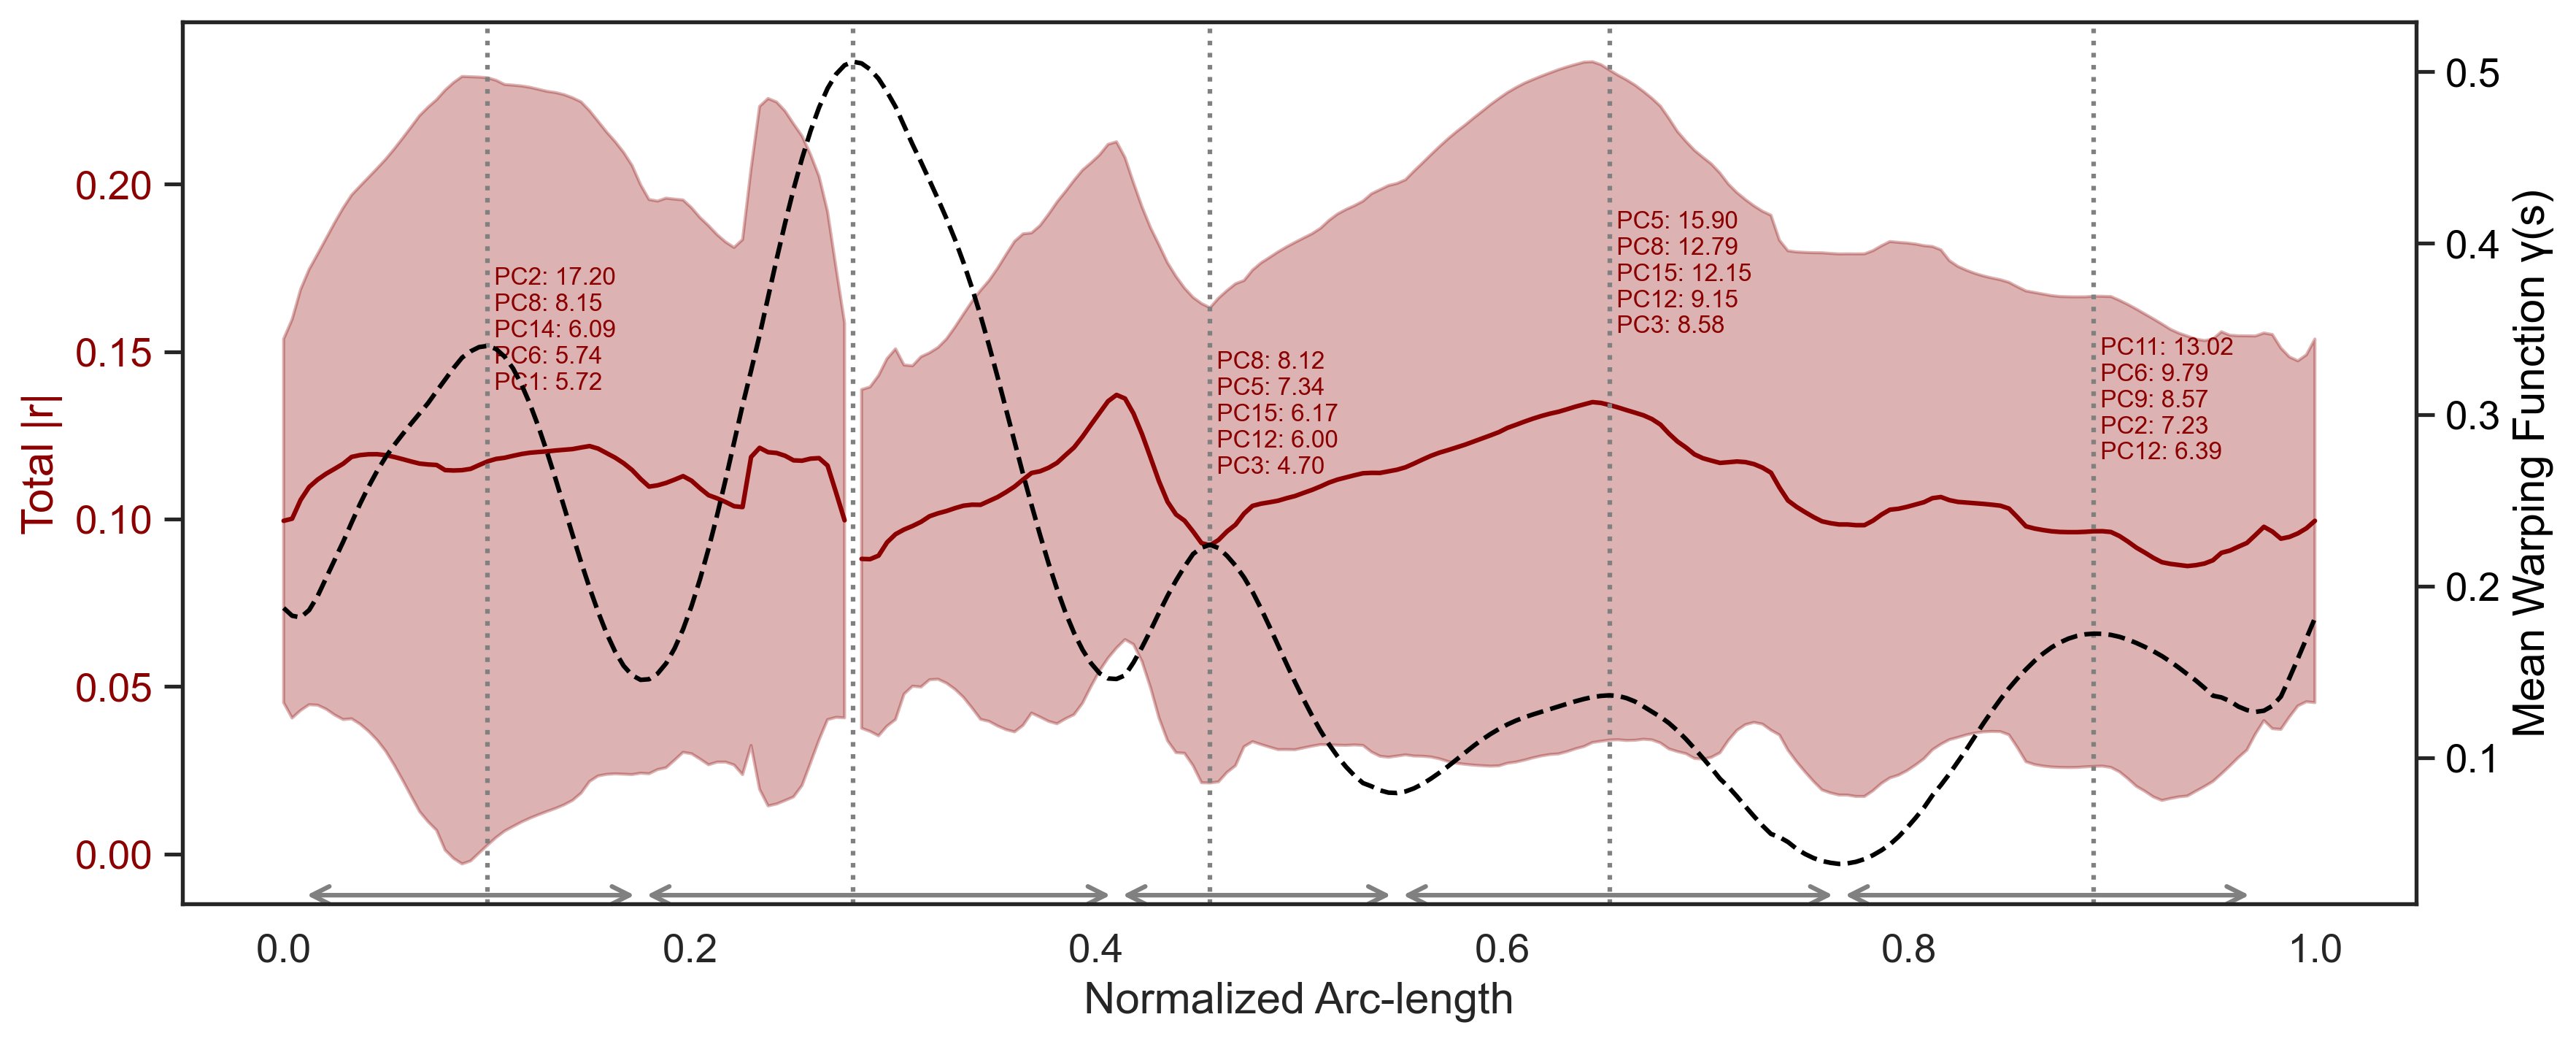

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="white", context="notebook", font_scale=1.2)

# ------------------------------------------------------------
# 1️⃣ 基础定义
gammas_raw = obj_weighted.gam.T    # shape (n_samples, n_points)
time_grid = time                   # normalized arc-length [0,1]
n_samples, n_points = gammas_raw.shape

# ------------------------------------------------------------
# 2️⃣ 使用 mean_curvature 找到所有peaks
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)
valleys, _ = find_peaks(-mean_curvature, distance=5)

print(f"Identified {len(peaks)} peaks (C0 ~ C{len(peaks)-1})")

# ------------------------------------------------------------
# 3️⃣ 以C1为对齐基准
c1_idx = peaks[1]
c1_time = time_grid[c1_idx]
print(f"C1 Index: {c1_idx}, C1 Time (normalized): {c1_time:.4f}")

gammas_aligned = np.zeros_like(gammas_raw)
for i in range(n_samples):
    offset = gammas_raw[i, c1_idx] - c1_time
    gammas_aligned[i, :] = gammas_raw[i, :] - offset

# ------------------------------------------------------------
# 4️⃣ 构建相关矩阵 R_gamma
n_components = tangent_projected_data.shape[1]
R_gamma = np.zeros((n_points, n_components))

for pc_index in range(n_components):
    pc_scores = tangent_projected_data[:, pc_index]
    for j in range(n_points):
        r, _ = pearsonr(pc_scores, gammas_aligned[:, j])
        R_gamma[j, pc_index] = r

# ------------------------------------------------------------
# 5️⃣ 统计模式强度
abs_R_gamma = np.abs(R_gamma)
mean_r_gamma = np.mean(abs_R_gamma, axis=1)
std_r_gamma = np.std(abs_R_gamma, axis=1)

# ------------------------------------------------------------
# 6️⃣ 每个mean_curve的峰值区间内的 top-k tPC 分析
topk = 5
top_tpcs = []
top_vals = []

for peak in peaks:
    left_valley_candidates = valleys[valleys < peak]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0

    right_valley_candidates = valleys[valleys > peak]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R_gamma.shape[0] - 1

    region_r = abs_R_gamma[left:right + 1, :]  # (region_len, n_components)
    summed_r = np.sum(region_r, axis=0)        # (n_components,)

    top_pc_indices = np.argsort(summed_r)[-topk:][::-1]
    top_pc_values = summed_r[top_pc_indices]

    top_tpcs.append(top_pc_indices)
    top_vals.append(top_pc_values)

top_tpcs = np.array(top_tpcs)
top_vals = np.array(top_vals)

# ------------------------------------------------------------
# 7️⃣ 可视化相关系数热图
plt.figure(figsize=(10, 6))
sns.heatmap(
    abs_R_gamma.T,
    cmap='viridis',
    cbar_kws={'label': '|r|'},
    xticklabels=20
)
plt.xlabel("Arc-length Parameter (normalized)")
plt.ylabel("tPCA Component Index")
plt.title("Pointwise |Correlation| between Warping Function γ(s) (C1-Aligned) and tPCA Components")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8️⃣ 曲线可视化 + γ均值 + 区间top-k标注
mean_gamma_aligned = gammas_aligned.mean(axis=0)

fig = plt.figure(figsize=(12, 5), dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(time_grid, mean_r_gamma, color='darkred', label='Mean |r|')
ax1.fill_between(
    time_grid,
    mean_r_gamma - std_r_gamma,
    mean_r_gamma + std_r_gamma,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

ax2.plot(time_grid, mean_curvature, color='black', linestyle='--', label='Mean γ(s) (C1-Aligned)')

# 标注每个peak区间
for i, idx in enumerate(peaks):
    left_valley_candidates = valleys[valleys < idx]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0
    right_valley_candidates = valleys[valleys > idx]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R_gamma.shape[0] - 1

    # 竖线
    ax1.axvline(time_grid[idx], color='gray', linestyle=':', alpha=1)

    # 区间箭头
    y_arrow = ax1.get_ylim()[0] + 0.01 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    ax1.annotate('', xy=(time_grid[right], y_arrow), xytext=(time_grid[left], y_arrow),
                 arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5), annotation_clip=False)

    # 文字标注
    label_text = '\n'.join([f" PC{pc+1}: {val:.2f}" for pc, val in zip(top_tpcs[i], top_vals[i])])
    ax1.text(time_grid[idx], mean_r_gamma[idx] + 0.02, label_text,
             color='darkred', fontsize=8, ha='left', va='bottom')

# 美化
ax1.set_xlabel("Normalized Arc-length")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Mean Warping Function γ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()


In [34]:
# # 计算所有切线方向
# tangent_vectors = np.diff(curve_cs, axis=1)  # (n_samples, n_points - 1, 3)
# tangent_norms = np.linalg.norm(tangent_vectors, axis=2, keepdims=True) + 1e-8
# tangent_dirs = tangent_vectors / tangent_norms

# arc_length_points = tangent_dirs.shape[1]

# # Step 1: 计算「均值方向」曲线
# mean_tangent = tangent_dirs.mean(axis=0)  # (arc_length_points, 3)
# mean_tangent_norms = np.linalg.norm(mean_tangent, axis=1, keepdims=True) + 1e-8
# mean_tangent_dirs = mean_tangent / mean_tangent_norms

# # Step 2: 计算所有样本与均值方向的 cos(θ) 曲线
# cos_angles = np.sum(tangent_dirs * mean_tangent_dirs[None, :, :], axis=2)  # (n_samples, arc_length_points)

# # Step 3: 与 tPC 分数做相关
# angle_correlations = np.zeros((tangent_projected_data.shape[1], arc_length_points))

# for pc_index in range(tangent_projected_data.shape[1]):
#     pc_scores = tangent_projected_data[:, pc_index]
#     for j in range(arc_length_points):
#         angle_correlations[pc_index, j], _ = pearsonr(pc_scores, cos_angles[:, j])

# print("✅ Computed cosine-angle correlation curves")

# fig, axes = plt.subplots(n_components, 1, figsize=(12, 2 * n_components), sharex=True)

# for pc_index in range(n_components):
#     ax = axes[pc_index]
#     ax.plot(angle_correlations[pc_index], color='darkred')
#     ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
#     ax.set_title(f'PC{pc_index + 1} - Cosine-angle Deviation Correlation')
#     ax.grid(False)

# plt.xlabel('Arc-length Parameter (index)')
# plt.tight_layout()
# plt.show()


In [35]:
# 还需要用同样的方式研究位移

- PC1让坐标在哪个方向（可能不一定是XYZ正方向）上变化最大？
- PC1让哪个段（可能用landmarks分段？）上变化最大？

```
obj = obj_plain
print("gamma:", hasattr(obj, 'gam'))
if hasattr(obj, 'gam'):
    print("gamma shape:", obj.gam.shape)
```

gamma: True
gamma shape: (240, 91)

```
import pickle

# 保存字典为 pkl 文件
output_path = "vtk_data_dict.pkl"
with open(output_path, "wb") as f:
    pickle.dump(vtk_data_dict, f)

print(f"字典已保存为: {output_path}")
```


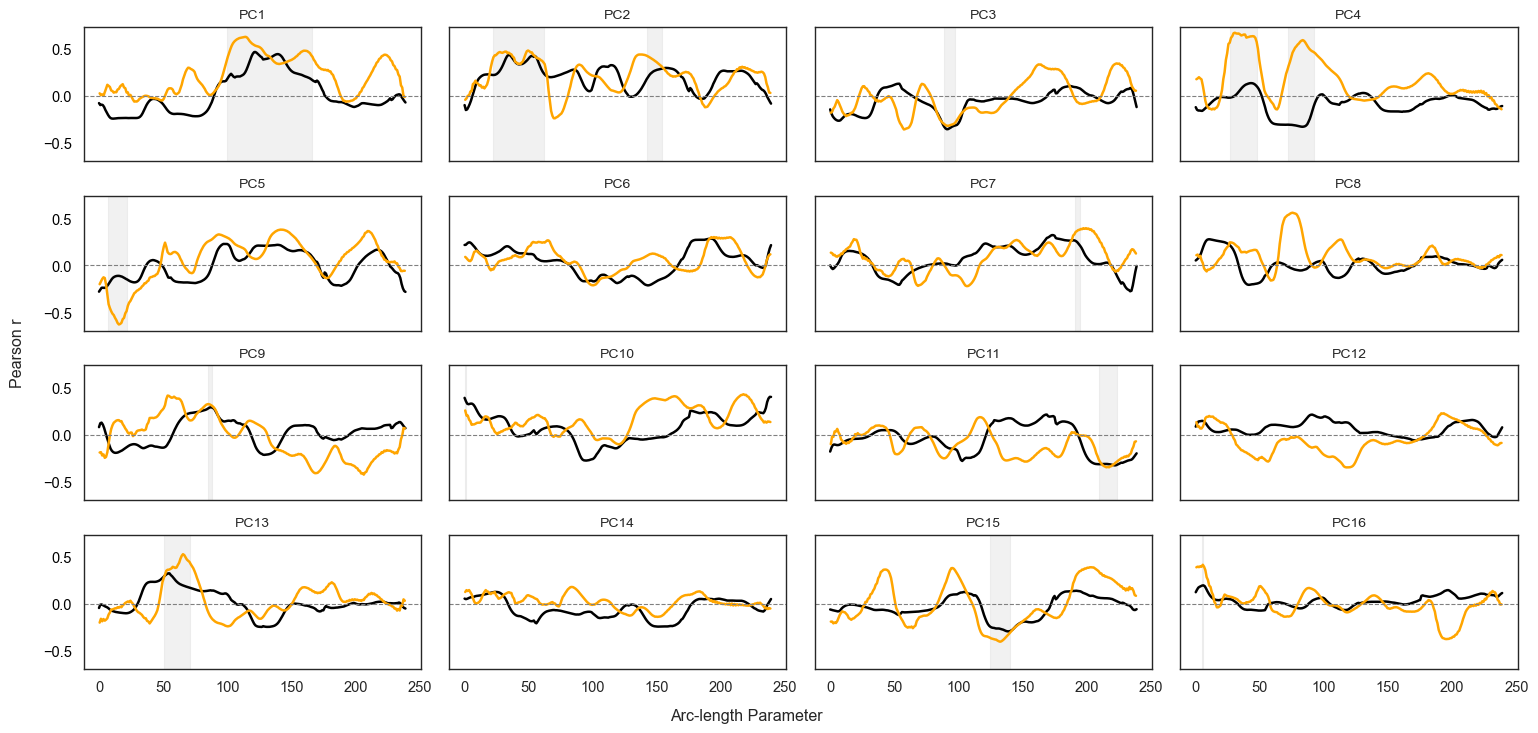

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.signal import find_peaks
import seaborn as sns

sns.set(style="white", context="paper", font_scale=1.2)

# -------------------------------
# 参数
n_components = tangent_projected_data.shape[1]
n_cols = 4
n_rows = int(np.ceil(n_components / n_cols))
arc_len = f_weighted_unwrapped.shape[0]

# -------------------------------
# 预先计算所有曲线的切线向量并单位化
tangent_devs = []
for i in range(curve_cs.shape[0]):
    diffs = np.diff(curve_cs[i], axis=0)
    norms = np.linalg.norm(diffs, axis=1, keepdims=True)
    diffs /= norms
    tangent_devs.append(diffs)
tangent_devs = np.array(tangent_devs)  # (n_samples, arc_len - 1, 3)

# 均值方向
mean_tangent = np.mean(tangent_devs, axis=0)
mean_tangent /= np.linalg.norm(mean_tangent, axis=1, keepdims=True)

# 对齐切线角度偏离
cos_angles = np.sum(tangent_devs * mean_tangent[None, :, :], axis=2)
angle_deviation = 1 - cos_angles  # shape (n_samples, arc_len - 1)

# -------------------------------
# 画图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]
    pc_scores = tangent_projected_data[:, pc_index]
    threshold = np.median(pc_scores)
    high_idx = pc_scores > threshold
    low_idx = pc_scores <= threshold

    # 曲率 vs PC
    curvature_corrs = np.array([
        pearsonr(pc_scores, f_weighted_unwrapped[j, :])[0]
        for j in range(f_weighted_unwrapped.shape[0])
    ])

    # 角度偏离 vs PC
    angle_corrs = np.array([
        pearsonr(pc_scores, angle_deviation[:, j])[0]
        for j in range(angle_deviation.shape[1])
    ])

    # -----------------------------
    # 新增：标注高相关背景
    combined_strength = np.abs(curvature_corrs[:len(angle_corrs)]) + np.abs(angle_corrs)
    threshold_corr = 0.6  # 可调
    high_corr_mask = combined_strength > threshold_corr

    in_block = False
    block_start = 0
    for i, val in enumerate(high_corr_mask):
        if val and not in_block:
            block_start = i
            in_block = True
        elif not val and in_block:
            ax.axvspan(block_start, i, color='lightgray', alpha=0.3)
            in_block = False
    if in_block:
        ax.axvspan(block_start, len(high_corr_mask), color='lightgray', alpha=0.3)

    # -----------------------------
    # 画左轴
    ax.plot(curvature_corrs, color='black', linewidth=1.8, label='Curvature Corr')
    ax.plot(np.arange(len(angle_corrs)) + 0.5, angle_corrs, color='orange', linewidth=1.8, label='Tangent Angle Corr')
    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)

    ax.set_title(f'PC{pc_index + 1}', fontsize=10)
    ax.tick_params(axis='y', labelcolor='black')
    ax.grid(False)

# 去掉多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

fig.text(0.5, 0.04, 'Arc-length Parameter', ha='center')
fig.text(0.04, 0.5, 'Pearson r', va='center', rotation='vertical')

fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()
